# Initialize

## Initialization

In [1]:
import os
import json
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd=tfp.distributions
import pandas as pd
from timeit import default_timer as timer
from jupyterthemes import jtplot
jtplot.reset()
sys.path.append('../code')
import Bijectors,Distributions,Metrics,MixtureDistributions,Plotters,Trainer,Utils
paper_fig_dir = "../../../NormalizingFlows/papers/NFHD/figures/"

## Useful functions

In [3]:
def reset_random_seeds(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [4]:
def MixtureGaussian(ncomp,ndims,seed=0):
    targ_dist = MixtureDistributions.MixMultiNormal1(ncomp,ndims,seed=seed)
    return targ_dist

In [13]:
def build_data_from_runs(path,save_file_name,only_succeeded=True):
    if only_succeeded:
        result_string = "succeeded"
    else:
        result_string = "all"
    print("Processing path", path,"for",result_string,"runs.")
    runs_list=[[int(i.replace("run_","")),os.path.abspath(os.path.join(os.path.join(path,i),"results.txt"))] for i in os.listdir(path) if ("run" in i and os.path.isdir(os.path.abspath(os.path.join(path,i))))]
    runs_list.sort()
    i=0
    j=0
    data=pd.DataFrame()
    for run in runs_list:
        proceed = True
        try:
            if os.path.exists(run[1]):
                print(run[1])
                tmp = pd.read_csv(run[1])#.pop("time")
                if 'nan' in str(tmp) or "failed" in str(tmp):
                    if not only_succeeded:
                        proceed = True
                    else:
                        proceed = False
                else:
                    proceed = True
                #if not 'pippo' in str(tmp):
                #    tmp = recompute_metrics(run[1])
                #else:
                #    pass
                if proceed:
                    data=pd.concat([data,tmp])
                else:
                    pass
                i=i+1
            else:
                j=j+1
                print("No results available for run",run[0])
        except:
            j=j+1
            print("Failed to import run",run[0])
    data = data.reset_index(drop=True).replace("failed","nan")
    print("Succesfully imported", i, "runs (failed to import",j,"runs).")
    save_path = os.path.abspath(os.path.join(path,save_file_name))
    data.to_csv(save_path,index=False)
    print("Succesfully saved data to file", save_path)
    return data

In [9]:
def recompute_metrics(run):
    print("Recomputing metrics for run",run.replace("results.txt",""),".")
    start_all=timer()
    tmp = pd.read_csv(run)
    X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
    np.shape(X_data_nf)
    run_n=int(tmp["run_n"])
    run_seed=int(tmp["run_seed"])
    ndims=int(tmp["ndims"])
    nsamples=int(tmp["nsamples"])
    correlation=str(tmp["correlation"][0])
    nbijectors=int(tmp["nbijectors"])
    bijector=str(tmp["bijector"][0])
    activation=str(tmp["activation"][0])
    spline_knots=int(tmp["spline_knots"])
    range_min=int(tmp["range_min"])
    eps_regulariser=tmp["eps_regulariser"][0]
    regulariser=tmp["regulariser"][0]
    hidden_layers=str(tmp["hidden_layers"][0])
    batch_size=int(tmp["batch_size"])
    epochs_input=int(tmp["epochs_input"])
    epochs_output=int(tmp["epochs_output"])
    time=tmp["time"][0]
    ncomp=3
    ntest_samples=nsamples
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    start=timer()
    ks_mean,ks_std,ad_mean,ad_std,wd_mean,wd_std,swd_mean,swd_std,fn_mean,fn_std=Metrics.ComputeMetrics(X_data_test,X_data_nf)
    results_dict = {'run_n': [run_n],
                    'run_seed': [run_seed],
                    'ndims':[ndims],
                    'nsamples':[nsamples],
                    'correlation':[correlation],
                    'nbijectors':[nbijectors],
                    'bijector':[bijector],
                    'activation':[activation],
                    'spline_knots':[spline_knots],
                    'range_min':[range_min],
                    'eps_regulariser':[eps_regulariser],
                    'regulariser':[regulariser],
                    'ks_mean':[ks_mean],
                    'ks_std':[ks_std],
                    'ad_mean':[ad_mean],
                    'ad_std':[ad_std],
                    'wd_mean':[wd_mean],
                    'wd_std':[wd_std],
                    'swd_mean':[swd_mean],
                    'swd_std':[swd_std],
                    'fn_mean':[fn_mean],
                    'fn_std':[fn_std],
                    'hidden_layers':[hidden_layers],
                    'batch_size':[batch_size],
                    'epochs_input':[epochs_input],
                    'epochs_output':[epochs_output],
                    'time':[time]}
    #os.rename(run, run.replace(".txt","_old.txt"))
    Utils.results_current(run.replace("results.txt",""),results_dict)
    tmp_new = pd.read_csv(run)
    end=timer()
    print("Metrics for run",run.replace("results.txt",""),"computed and saved in",end-start,"s.")
    return tmp_new

In [10]:
def extract_lines(df_bests,bij,corr,metric,mean_std=False):
    result = []
    for df in df_bests:
        if mean_std:
            tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric+"_mean",metric+"_std","run_n"]].to_numpy().flatten().tolist()
        else:
            tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric,"run_n"]].to_numpy().flatten().tolist()
        if tmp != []:
            result.append(tmp)
    return np.array(result)

## Check, fix, import results

### Check and fix results

In [11]:
correlated_results_paths = {"MAFN": "../CMoG/results/MAFN/",
                           "RealNVPN": "../CMoG/results/RealNVPN/",
                           "MsplineN": "../CMoG/results/MsplineN/",
                           "CsplineN": "../CMoG/results/CsplineN/"
                          }
correlated_unc_results_paths = {"MAFN": "../CMoG/results/MAFN_best/",
                                "RealNVPN": "../CMoG/results/RealNVPN_best/",
                                "MsplineN": "../CMoG/results/MsplineN_best/",
                                "CsplineN": "../CMoG/results/CsplineN_best/"
                               }

In [ ]:
#import shutil
#for path in correlated_results_paths.values():
#    #path=correlated_results_paths["MAFN"]
#    print(path)
#    runs_list=[os.path.abspath(os.path.join(os.path.join(path,i),"results.txt")) for i in os.listdir(path) if ("run" in i and os.path.isdir(os.path.abspath(os.path.join(path,i))))]
#    for r in runs_list:
#        source_path=r.replace("NF4HEP/NormalizingFlowsHD","NF4HEP/NormalizingFlowsHD-2/Riccardo")
#        destination_path=r.replace("results.txt","results_bkp.txt")
#        shutil.copy2(source_path, destination_path)
#        print([source_path,destination_path,"Done."])

#### Runs

In [12]:
for res in correlated_results_paths.values():
    build_data_from_runs(res,"log_file_eternal_final.txt")

Processing path ../CMoG/results/MAFN/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_1/ .


2023-05-18 11:58:50.208643: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_OUT_OF_MEMORY: out of memory
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_1/ computed and saved in 11.478941135006608 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_2/ computed and saved in 10.958891577000031 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_3/ computed and saved in 11.611564578008256 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_4/ computed and saved in 10.807675059011672 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_5/ computed and saved in 12.743351390992757 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_6/ computed and saved in 11.07366283799638 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_7/ computed and saved in 11.00978653600032 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_8/ computed and saved in 11.762177115000668 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_9/ computed and saved in 12.730525947001297 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_10/ computed and saved in 12.576809184000012 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_11/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_11/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_11/ computed and saved in 13.22568919499463 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_12/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_12/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_12/ computed and saved in 12.892755053995643 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_13/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_13/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_13/ computed and saved in 16.574928772999556 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_14/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_14/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_14/ computed and saved in 16.898692575996392 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_15/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_15/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_15/ computed and saved in 15.905957843002398 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_16/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_16/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_16/ computed and saved in 16.03014457601239 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_17/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_17/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_17/ computed and saved in 25.825375739994342 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_18/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_18/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_18/ computed and saved in 24.673974921010085 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_19/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_19/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_19/ computed and saved in 27.354138259994215 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_20/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_20/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_20/ computed and saved in 25.04261879400292 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_21/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_21/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_21/ computed and saved in 30.07436829600192 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_22/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_22/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_22/ computed and saved in 30.613755335987662 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_23/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_23/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_23/ computed and saved in 26.619323181002983 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_24/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_24/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_24/ computed and saved in 26.992049794003833 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_25/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_25/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_25/ computed and saved in 43.79270713000733 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_26/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_26/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_26/ computed and saved in 45.15027165200445 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_27/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_27/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_27/ computed and saved in 43.45616249900195 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_28/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_28/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_28/ computed and saved in 43.664903369994136 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_29/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_29/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_29/ computed and saved in 76.6180972699949 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_30/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_30/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_30/ computed and saved in 76.16212545899907 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_31/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_31/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_31/ computed and saved in 79.86661283099966 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_32/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_32/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_32/ computed and saved in 91.82034008500341 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_33/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_33/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_33/ computed and saved in 242.37035682599526 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_34/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_34/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_34/ computed and saved in 237.23809392401017 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_35/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_35/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_35/ computed and saved in 234.95948939899972 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_36/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_36/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_36/ computed and saved in 212.91207677200146 s.
Succesfully imported 36 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/log_file_eternal_final.txt
Processing path ../CMoG/results/RealNVPN/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_1/ computed and saved in 20.76124589999381 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_2/ computed and saved in 17.31671878400084 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_3/ computed and saved in 17.634980287999497 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_4/ computed and saved in 12.404487640000298 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_5/ computed and saved in 12.256068198999856 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_6/ computed and saved in 11.287270462009474 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_7/ computed and saved in 11.710501510999165 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_8/ computed and saved in 11.578686481996556 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_9/ computed and saved in 12.38019464899844 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_10/ computed and saved in 12.039386786011164 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_11/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_11/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_11/ computed and saved in 13.951484677003464 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_12/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_12/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_12/ computed and saved in 13.063217750997865 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_13/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_13/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_13/ computed and saved in 16.74700378999114 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_14/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_14/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_14/ computed and saved in 15.388438308000332 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_15/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_15/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_15/ computed and saved in 15.437688481993973 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_16/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_16/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_16/ computed and saved in 15.091887583999778 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_17/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_17/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_17/ computed and saved in 21.831933544002823 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_18/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_18/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_18/ computed and saved in 20.076391983006033 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_19/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_19/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_19/ computed and saved in 20.942167476998293 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_20/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_20/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_20/ computed and saved in 21.140873488009674 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_21/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_21/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_21/ computed and saved in 57.28624076099368 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_22/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_22/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_22/ computed and saved in 53.131337931001326 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_23/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_23/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_23/ computed and saved in 27.729286117988522 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_24/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_24/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_24/ computed and saved in 27.12894219699956 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_25/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_25/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_25/ computed and saved in 41.10946406300354 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_26/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_26/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_26/ computed and saved in 43.8120364970091 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_27/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_27/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_27/ computed and saved in 47.995585563010536 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_28/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_28/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_28/ computed and saved in 92.83393748399976 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_29/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_29/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_29/ computed and saved in 88.68319706399052 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_30/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_30/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_30/ computed and saved in 82.099468194996 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_31/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_31/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_31/ computed and saved in 133.93380352199893 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_32/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_32/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_32/ computed and saved in 78.27467215700017 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_33/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_33/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_33/ computed and saved in 229.53776890000154 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_34/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_34/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_34/ computed and saved in 233.15917012099817 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_35/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_35/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_35/ computed and saved in 238.21587715600617 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_36/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_36/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_36/ computed and saved in 254.11267205199692 s.
Succesfully imported 36 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/log_file_eternal_final.txt
Processing path ../CMoG/results/MsplineN/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_1/ computed and saved in 17.511300069993013 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_2/ computed and saved in 12.286589321010979 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_3/ computed and saved in 10.985993523994694 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_4/ computed and saved in 10.81636953400448 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_5/ computed and saved in 11.087437113004853 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_6/ computed and saved in 11.984242509992328 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_7/ computed and saved in 16.068196749009076 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_8/ computed and saved in 17.64075557499018 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_9/ computed and saved in 12.212382601996069 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_10/ computed and saved in 12.908670535995043 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_11/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_11/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_11/ computed and saved in 12.630330439002137 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_12/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_12/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_12/ computed and saved in 14.157796810002765 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_13/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_13/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_13/ computed and saved in 25.4829922659992 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_14/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_14/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_14/ computed and saved in 15.881306793002295 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_15/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_15/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_15/ computed and saved in 15.443532531004166 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_16/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_16/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_16/ computed and saved in 20.820655844989233 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_17/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_17/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_17/ computed and saved in 26.344860704994062 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_18/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_18/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_18/ computed and saved in 22.536089696004638 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_19/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_19/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_19/ computed and saved in 33.10013637499651 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_20/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_20/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_20/ computed and saved in 21.878074009000557 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_21/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_21/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_21/ computed and saved in 36.2470110610011 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_22/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_22/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_22/ computed and saved in 25.706216299004154 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_23/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_23/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_23/ computed and saved in 35.64868188499531 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_24/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_24/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_24/ computed and saved in 26.824980610006605 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_25/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_25/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_25/ computed and saved in 71.60100519699336 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_26/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_26/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_26/ computed and saved in 67.12102830799995 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_27/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_27/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_27/ computed and saved in 70.11258483600977 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_28/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_28/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_28/ computed and saved in 43.07054437800252 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_29/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_29/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_29/ computed and saved in 89.87188843000331 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_30/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_30/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_30/ computed and saved in 92.137111360993 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_31/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_31/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_31/ computed and saved in 88.68970969899965 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_32/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_32/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_32/ computed and saved in 94.40682890699827 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_33/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_33/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_33/ computed and saved in 225.84602391500084 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_34/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_34/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_34/ computed and saved in 211.86158636500477 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_35/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_35/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_35/ computed and saved in 305.0491722949955 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_36/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_36/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/run_36/ computed and saved in 271.49756666600297 s.
Succesfully imported 36 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN/log_file_eternal_final.txt
Processing path ../CMoG/results/CsplineN/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_1/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_1/ computed and saved in 10.884143243005383 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_2/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_2/ computed and saved in 10.998318399986601 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_3/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_3/ computed and saved in 11.265170200000284 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_4/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_4/ computed and saved in 10.229103630001191 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_5/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_5/ computed and saved in 10.441199006003444 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_6/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_6/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_6/ computed and saved in 11.066908556997078 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_7/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_7/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_7/ computed and saved in 9.769682352998643 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_8/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_8/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_8/ computed and saved in 10.853188053006306 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_9/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_9/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_9/ computed and saved in 10.785033369000303 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_10/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_10/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_10/ computed and saved in 10.40337831999932 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_11/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_11/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_11/ computed and saved in 11.025746826999239 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_12/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_12/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_12/ computed and saved in 10.776367985003162 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_13/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_13/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_13/ computed and saved in 11.01792415601085 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_14/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_14/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_14/ computed and saved in 11.242093576991465 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_15/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_15/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_15/ computed and saved in 12.085794444996282 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_16/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_16/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_16/ computed and saved in 19.551122923992807 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_17/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_17/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_17/ computed and saved in 23.74100682999415 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_18/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_18/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_18/ computed and saved in 22.898806311990484 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_19/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_19/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_19/ computed and saved in 13.584139326005243 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_20/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_20/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_20/ computed and saved in 12.973781763997977 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_21/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_21/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_21/ computed and saved in 12.388431466999464 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_22/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_22/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_22/ computed and saved in 11.907442301002447 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_23/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_23/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_23/ computed and saved in 11.289367495002807 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_24/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_24/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_24/ computed and saved in 12.03435597900534 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_25/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_25/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_25/ computed and saved in 14.401208039998892 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_26/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_26/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_26/ computed and saved in 12.56761156799621 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_27/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_27/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_27/ computed and saved in 12.323653297004057 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_28/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_28/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_28/ computed and saved in 12.906746669992572 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_29/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_29/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_29/ computed and saved in 12.554327809004462 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_30/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_30/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_30/ computed and saved in 12.780205775998184 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_31/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_31/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_31/ computed and saved in 13.261263163003605 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_32/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_32/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_32/ computed and saved in 12.393628025994985 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_33/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_33/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_33/ computed and saved in 13.081935046997387 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_34/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_34/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_34/ computed and saved in 13.703661653999006 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_35/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_35/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_35/ computed and saved in 12.293002553997212 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_36/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_36/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_36/ computed and saved in 12.017859736995888 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_37/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_37/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_37/ computed and saved in 15.431153847006499 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_38/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_38/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_38/ computed and saved in 15.681743695007754 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_39/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_39/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_39/ computed and saved in 16.78798481100239 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_40/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_40/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_40/ computed and saved in 29.4031868029997 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_41/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_41/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_41/ computed and saved in 27.81714428900159 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_42/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_42/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_42/ computed and saved in 15.925460136000765 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_43/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_43/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_43/ computed and saved in 12.287065028009238 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_44/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_44/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_44/ computed and saved in 11.226905096991686 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_45/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_45/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_45/ computed and saved in 10.869687224010704 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_46/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_46/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_46/ computed and saved in 11.187810506002279 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_47/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_47/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_47/ computed and saved in 11.49302464199718 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_48/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_48/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_48/ computed and saved in 15.830082710992428 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_49/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_49/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_49/ computed and saved in 16.450957870009006 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_50/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_50/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_50/ computed and saved in 20.344539754994912 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_51/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_51/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_51/ computed and saved in 21.368096105012228 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_52/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_52/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_52/ computed and saved in 21.7813738489931 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_53/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_53/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_53/ computed and saved in 21.611619372997666 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_54/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_54/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_54/ computed and saved in 20.795373341999948 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_55/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_55/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_55/ computed and saved in 28.693756064007175 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_56/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_56/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_56/ computed and saved in 35.07309481399716 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_57/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_57/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_57/ computed and saved in 16.06722960199113 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_58/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_58/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_58/ computed and saved in 14.680544162998558 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_59/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_59/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_59/ computed and saved in 15.910785099011264 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_60/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_60/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_60/ computed and saved in 16.941272095005843 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_61/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_61/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_61/ computed and saved in 20.134673089996795 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_62/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_62/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_62/ computed and saved in 19.049776557993027 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_63/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_63/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_63/ computed and saved in 25.90722426000866 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_64/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_64/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_64/ computed and saved in 20.47606184599863 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_65/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_65/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_65/ computed and saved in 19.41727813599573 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_66/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_66/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_66/ computed and saved in 21.96818142499251 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_67/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_67/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_67/ computed and saved in 46.369778605992906 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_68/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_68/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_68/ computed and saved in 20.87723548199574 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_69/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_69/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_69/ computed and saved in 19.998600394988898 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_70/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_70/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_70/ computed and saved in 19.420918993011583 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_71/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_71/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_71/ computed and saved in 19.506969374997425 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_72/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_72/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_72/ computed and saved in 21.41702784699737 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_73/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_73/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_73/ computed and saved in 34.97396809000929 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_74/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_74/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_74/ computed and saved in 32.77311358899169 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_75/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_75/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_75/ computed and saved in 65.59854389200336 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_76/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_76/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_76/ computed and saved in 33.84329095300927 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_77/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_77/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_77/ computed and saved in 33.97877740999684 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_78/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_78/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_78/ computed and saved in 34.383945467998274 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_79/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_79/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_79/ computed and saved in 33.62795012300194 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_80/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_80/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_80/ computed and saved in 60.12254860100802 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_81/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_81/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_81/ computed and saved in 35.363105113006895 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_82/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_82/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_82/ computed and saved in 33.80839585600188 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_83/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_83/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_83/ computed and saved in 34.85308830300346 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_84/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_84/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_84/ computed and saved in 35.190863628988154 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_85/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_85/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_85/ computed and saved in 93.11284896699362 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_86/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_86/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_86/ computed and saved in 64.68172941800731 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_87/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_87/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_87/ computed and saved in 64.01878638099879 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_88/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_88/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_88/ computed and saved in 88.02534159799688 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_89/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_89/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_89/ computed and saved in 62.58837079400837 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_90/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_90/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_90/ computed and saved in 61.36468488899118 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_91/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_91/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_91/ computed and saved in 87.95387660100823 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_92/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_92/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_92/ computed and saved in 62.01367301499704 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_93/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_93/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_93/ computed and saved in 61.933697911998024 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_94/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_94/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_94/ computed and saved in 98.59649024800456 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_95/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_95/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_95/ computed and saved in 86.4718063439941 s.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_96/results.txt
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_96/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:241: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_96/ computed and saved in 85.98160109300807 s.
Succesfully imported 96 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/log_file_eternal_final.txt


#### Uncertainties

In [14]:
for res in correlated_unc_results_paths.values():
    runs = [res+"/"+i+"/" for i in os.listdir(res)]
    for res_runs in runs:
        build_data_from_runs(res_runs,"log_file_eternal_final.txt")

Processing path ../CMoG/results/MAFN_best//1000D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_1/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_2/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_3/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_4/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_5/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_6/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHu

Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/log_file_eternal_final.txt
Processing path ../CMoG/results/MAFN_best//400D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_1/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_2/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_3/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_4/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_8/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_9/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_10/results.txt
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/log_file_eternal_final.txt
Processing path ../CMoG/results/RealNVPN_best//100D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_1/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/N

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/run_6/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/run_7/results.txt
No results available for run 8
Succesfully imported 7 runs (failed to import 1 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/400D/log_file_eternal_final.txt
Processing path ../CMoG/results/RealNVPN_best//4D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_1/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_2/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/Normal

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_3/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_4/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_5/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_6/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_7/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_8/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/64D/run_6/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/64D/run_7/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/64D/run_8/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/64D/run_9/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/64D/run_10/results.txt
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/64D/log_file_eternal_final.txt
Processing path

### Import results

#### Runs

In [15]:
tmp_paths = {k: v+"log_file_eternal_final.txt" for k,v in correlated_results_paths.items()}
tmp = {k: pd.read_csv(tmp_paths[k]) for k in tmp_paths.keys()}
try:
    for k in tmp.keys():
        tmp[k]["epochs_input"] = tmp[k]["epochs_input"].fillna(1000)
        tmp[k]["epochs_output"] = tmp[k]["epochs_output"].fillna(0)
except:
    pass
df_correlated = pd.concat([df for df in tmp.values()],ignore_index=True).dropna().reset_index(drop=True)
df_correlated = df_correlated[~(df_correlated == 'failed').any(axis=1)]
len(df_correlated)

157

In [16]:
df_correlated

run_n  run_seed  ndims  nsamples correlation  nbijectors  bijector  \
0        1         0      4    100000        corr           5      MAFN   
1        2         0      4    100000        corr           5      MAFN   
2        3         0      4    100000        corr          10      MAFN   
3        4         0      4    100000        corr          10      MAFN   
4        5         0      8    100000        corr           5      MAFN   
..     ...       ...    ...       ...         ...         ...       ...   
152     51         0     64    100000        corr           5  CsplineN   
153     52         0     64    100000        corr           5  CsplineN   
154     53         0     64    100000        corr           5  CsplineN   
155     54         0     64    100000        corr           5  CsplineN   
156     63         0    100    100000        corr           5  CsplineN   

    activation  spline_knots  range_min  ...    wd_std  swd_mean   swd_std  \
0         relu             8         -5  ...  0.011880  0.029394  0.012714   
1         relu             8         -5  ...  0.011148  0.027307  0.011358   
2         relu             8         -5  ...  0.011683  0.032942  0.015316   
3         relu             8         -5  ...  0.012653  0.040439  0.018065   
4         relu             8         -5  ...  0.023241  0.041212  0.022324   
..         ...           ...        ...  ...       ...       ...       ...   
152       relu             8        -16  ...  0.052517  0.097759  0.054988   
153       relu            12        -16  ...  0.028621  0.050309  0.032722   
154       relu            12        -16  ...  0.031050  0.069015  0.034801   
155       relu            12        -16  ...  0.043200  0.082895  0.045368   
156       relu             8        -16  ...  0.060951  0.105275  0.063527   

      fn_mean    fn_std  hidden_layers  batch_size  epochs_input  \
0    0.043974  0.013159    128-128-128         512          1000   
1    0.034974  0.014084    256-256-256         512          1000   
2    0.025757  0.007126    128-128-128         512          1000   
3    0.054567  0.014298    256-256-256         512          1000   
4    0.078752  0.020209    128-128-128         512          1000   
..        ...       ...            ...         ...           ...   
152  1.206197  0.068597    512-512-512         512          1000   
153  0.858337  0.171722    128-128-128         512          1000   
154  1.181459  0.030153    256-256-256         512          1000   
155  1.222647  0.082691    512-512-512         512          1000   
156  2.368010  0.281556    512-512-512         512          1000   

     epochs_output         time  
0              323   745.240984  
1              361   833.398603  
2              288  1834.018883  
3              202   901.423236  
4              327   752.582348  
..             ...          ...  
152            109  2482.542158  
153            249  6506.313299  
154            152  3980.556303  
155            110  2915.697962  
156            148  3317.098976  

[157 rows x 27 columns]

#### Uncertainties

In [17]:
correlated_unc_results_paths

{'MAFN': '../CMoG/results/MAFN_best/',
 'RealNVPN': '../CMoG/results/RealNVPN_best/',
 'MsplineN': '../CMoG/results/MsplineN_best/',
 'CsplineN': '../CMoG/results/CsplineN_best/'}

In [22]:
tmp_paths = {}
for k,v in correlated_unc_results_paths.items():
    runs = [v+"/"+i+"/log_file_eternal_final.txt" for i in os.listdir(v)]
    tmp_paths[k] = runs
flat_list = list()
for runs in list(tmp_paths.values()):
    flat_list += runs
tmp = []
for f in flat_list:
    #rint("Working on file",f)
    try:
        ttmp = pd.read_csv(f)
        try:
            for j in ttmp.keys():
                ttmp[j]["epochs_input"] = ttmp[j]["epochs_input"].fillna(1000)
                ttmp[j]["epochs_output"] = ttmp[j]["epochs_output"].fillna(0)
        except:
            pass
        tmp.append(ttmp)
    except:
        pass
df_correlated_unc = pd.concat([df for df in tmp],ignore_index=True).dropna().reset_index(drop=True)
df_correlated_unc = df_correlated_unc[~(df_correlated_unc == 'failed').any(axis=1)]
len(df_correlated_unc)

[   run_n  run_seed  ndims  nsamples correlation  nbijectors bijector  \
0      1         0   1000    100000        corr           5     MAFN   
1      2       187   1000    100000        corr           5     MAFN   
2      3       377   1000    100000        corr           5     MAFN   
3      4       440   1000    100000        corr           5     MAFN   
4      5       520   1000    100000        corr           5     MAFN   
5      6       541   1000    100000        corr           5     MAFN   
6      7       721   1000    100000        corr           5     MAFN   
7      8       869   1000    100000        corr           5     MAFN   
8      9       926   1000    100000        corr           5     MAFN   
9     10       933   1000    100000        corr           5     MAFN   

  activation  spline_knots  range_min  ...    wd_std  swd_mean   swd_std  \
0       relu             8         -5  ...  0.187069  0.415502  0.215458   
1       relu             8         -5  ...  0.298185  

[   run_n  run_seed  ndims  nsamples correlation  nbijectors bijector  \
0      1         0   1000    100000        corr           5     MAFN   
1      2       187   1000    100000        corr           5     MAFN   
2      3       377   1000    100000        corr           5     MAFN   
3      4       440   1000    100000        corr           5     MAFN   
4      5       520   1000    100000        corr           5     MAFN   
5      6       541   1000    100000        corr           5     MAFN   
6      7       721   1000    100000        corr           5     MAFN   
7      8       869   1000    100000        corr           5     MAFN   
8      9       926   1000    100000        corr           5     MAFN   
9     10       933   1000    100000        corr           5     MAFN   

  activation  spline_knots  range_min  ...    wd_std  swd_mean   swd_std  \
0       relu             8         -5  ...  0.187069  0.415502  0.215458   
1       relu             8         -5  ...  0.298185  

[   run_n  run_seed  ndims  nsamples correlation  nbijectors bijector  \
0      1         0   1000    100000        corr           5     MAFN   
1      2       187   1000    100000        corr           5     MAFN   
2      3       377   1000    100000        corr           5     MAFN   
3      4       440   1000    100000        corr           5     MAFN   
4      5       520   1000    100000        corr           5     MAFN   
5      6       541   1000    100000        corr           5     MAFN   
6      7       721   1000    100000        corr           5     MAFN   
7      8       869   1000    100000        corr           5     MAFN   
8      9       926   1000    100000        corr           5     MAFN   
9     10       933   1000    100000        corr           5     MAFN   

  activation  spline_knots  range_min  ...    wd_std  swd_mean   swd_std  \
0       relu             8         -5  ...  0.187069  0.415502  0.215458   
1       relu             8         -5  ...  0.298185  

[   run_n  run_seed  ndims  nsamples correlation  nbijectors bijector  \
0      1         0   1000    100000        corr           5     MAFN   
1      2       187   1000    100000        corr           5     MAFN   
2      3       377   1000    100000        corr           5     MAFN   
3      4       440   1000    100000        corr           5     MAFN   
4      5       520   1000    100000        corr           5     MAFN   
5      6       541   1000    100000        corr           5     MAFN   
6      7       721   1000    100000        corr           5     MAFN   
7      8       869   1000    100000        corr           5     MAFN   
8      9       926   1000    100000        corr           5     MAFN   
9     10       933   1000    100000        corr           5     MAFN   

  activation  spline_knots  range_min  ...    wd_std  swd_mean   swd_std  \
0       relu             8         -5  ...  0.187069  0.415502  0.215458   
1       relu             8         -5  ...  0.298185  

[   run_n  run_seed  ndims  nsamples correlation  nbijectors bijector  \
0      1         0   1000    100000        corr           5     MAFN   
1      2       187   1000    100000        corr           5     MAFN   
2      3       377   1000    100000        corr           5     MAFN   
3      4       440   1000    100000        corr           5     MAFN   
4      5       520   1000    100000        corr           5     MAFN   
5      6       541   1000    100000        corr           5     MAFN   
6      7       721   1000    100000        corr           5     MAFN   
7      8       869   1000    100000        corr           5     MAFN   
8      9       926   1000    100000        corr           5     MAFN   
9     10       933   1000    100000        corr           5     MAFN   

  activation  spline_knots  range_min  ...    wd_std  swd_mean   swd_std  \
0       relu             8         -5  ...  0.187069  0.415502  0.215458   
1       relu             8         -5  ...  0.298185  

[   run_n  run_seed  ndims  nsamples correlation  nbijectors bijector  \
0      1         0   1000    100000        corr           5     MAFN   
1      2       187   1000    100000        corr           5     MAFN   
2      3       377   1000    100000        corr           5     MAFN   
3      4       440   1000    100000        corr           5     MAFN   
4      5       520   1000    100000        corr           5     MAFN   
5      6       541   1000    100000        corr           5     MAFN   
6      7       721   1000    100000        corr           5     MAFN   
7      8       869   1000    100000        corr           5     MAFN   
8      9       926   1000    100000        corr           5     MAFN   
9     10       933   1000    100000        corr           5     MAFN   

  activation  spline_knots  range_min  ...    wd_std  swd_mean   swd_std  \
0       relu             8         -5  ...  0.187069  0.415502  0.215458   
1       relu             8         -5  ...  0.298185  

[   run_n  run_seed  ndims  nsamples correlation  nbijectors bijector  \
0      1         0   1000    100000        corr           5     MAFN   
1      2       187   1000    100000        corr           5     MAFN   
2      3       377   1000    100000        corr           5     MAFN   
3      4       440   1000    100000        corr           5     MAFN   
4      5       520   1000    100000        corr           5     MAFN   
5      6       541   1000    100000        corr           5     MAFN   
6      7       721   1000    100000        corr           5     MAFN   
7      8       869   1000    100000        corr           5     MAFN   
8      9       926   1000    100000        corr           5     MAFN   
9     10       933   1000    100000        corr           5     MAFN   

  activation  spline_knots  range_min  ...    wd_std  swd_mean   swd_std  \
0       relu             8         -5  ...  0.187069  0.415502  0.215458   
1       relu             8         -5  ...  0.298185  

[   run_n  run_seed  ndims  nsamples correlation  nbijectors bijector  \
0      1         0   1000    100000        corr           5     MAFN   
1      2       187   1000    100000        corr           5     MAFN   
2      3       377   1000    100000        corr           5     MAFN   
3      4       440   1000    100000        corr           5     MAFN   
4      5       520   1000    100000        corr           5     MAFN   
5      6       541   1000    100000        corr           5     MAFN   
6      7       721   1000    100000        corr           5     MAFN   
7      8       869   1000    100000        corr           5     MAFN   
8      9       926   1000    100000        corr           5     MAFN   
9     10       933   1000    100000        corr           5     MAFN   

  activation  spline_knots  range_min  ...    wd_std  swd_mean   swd_std  \
0       relu             8         -5  ...  0.187069  0.415502  0.215458   
1       relu             8         -5  ...  0.298185  

[   run_n  run_seed  ndims  nsamples correlation  nbijectors bijector  \
0      1         0   1000    100000        corr           5     MAFN   
1      2       187   1000    100000        corr           5     MAFN   
2      3       377   1000    100000        corr           5     MAFN   
3      4       440   1000    100000        corr           5     MAFN   
4      5       520   1000    100000        corr           5     MAFN   
5      6       541   1000    100000        corr           5     MAFN   
6      7       721   1000    100000        corr           5     MAFN   
7      8       869   1000    100000        corr           5     MAFN   
8      9       926   1000    100000        corr           5     MAFN   
9     10       933   1000    100000        corr           5     MAFN   

  activation  spline_knots  range_min  ...    wd_std  swd_mean   swd_std  \
0       relu             8         -5  ...  0.187069  0.415502  0.215458   
1       relu             8         -5  ...  0.298185  

[   run_n  run_seed  ndims  nsamples correlation  nbijectors bijector  \
0      1         0   1000    100000        corr           5     MAFN   
1      2       187   1000    100000        corr           5     MAFN   
2      3       377   1000    100000        corr           5     MAFN   
3      4       440   1000    100000        corr           5     MAFN   
4      5       520   1000    100000        corr           5     MAFN   
5      6       541   1000    100000        corr           5     MAFN   
6      7       721   1000    100000        corr           5     MAFN   
7      8       869   1000    100000        corr           5     MAFN   
8      9       926   1000    100000        corr           5     MAFN   
9     10       933   1000    100000        corr           5     MAFN   

  activation  spline_knots  range_min  ...    wd_std  swd_mean   swd_std  \
0       relu             8         -5  ...  0.187069  0.415502  0.215458   
1       relu             8         -5  ...  0.298185  

[   run_n  run_seed  ndims  nsamples correlation  nbijectors bijector  \
0      1         0   1000    100000        corr           5     MAFN   
1      2       187   1000    100000        corr           5     MAFN   
2      3       377   1000    100000        corr           5     MAFN   
3      4       440   1000    100000        corr           5     MAFN   
4      5       520   1000    100000        corr           5     MAFN   
5      6       541   1000    100000        corr           5     MAFN   
6      7       721   1000    100000        corr           5     MAFN   
7      8       869   1000    100000        corr           5     MAFN   
8      9       926   1000    100000        corr           5     MAFN   
9     10       933   1000    100000        corr           5     MAFN   

  activation  spline_knots  range_min  ...    wd_std  swd_mean   swd_std  \
0       relu             8         -5  ...  0.187069  0.415502  0.215458   
1       relu             8         -5  ...  0.298185  

[   run_n  run_seed  ndims  nsamples correlation  nbijectors bijector  \
0      1         0   1000    100000        corr           5     MAFN   
1      2       187   1000    100000        corr           5     MAFN   
2      3       377   1000    100000        corr           5     MAFN   
3      4       440   1000    100000        corr           5     MAFN   
4      5       520   1000    100000        corr           5     MAFN   
5      6       541   1000    100000        corr           5     MAFN   
6      7       721   1000    100000        corr           5     MAFN   
7      8       869   1000    100000        corr           5     MAFN   
8      9       926   1000    100000        corr           5     MAFN   
9     10       933   1000    100000        corr           5     MAFN   

  activation  spline_knots  range_min  ...    wd_std  swd_mean   swd_std  \
0       relu             8         -5  ...  0.187069  0.415502  0.215458   
1       relu             8         -5  ...  0.298185  

[   run_n  run_seed  ndims  nsamples correlation  nbijectors bijector  \
0      1         0   1000    100000        corr           5     MAFN   
1      2       187   1000    100000        corr           5     MAFN   
2      3       377   1000    100000        corr           5     MAFN   
3      4       440   1000    100000        corr           5     MAFN   
4      5       520   1000    100000        corr           5     MAFN   
5      6       541   1000    100000        corr           5     MAFN   
6      7       721   1000    100000        corr           5     MAFN   
7      8       869   1000    100000        corr           5     MAFN   
8      9       926   1000    100000        corr           5     MAFN   
9     10       933   1000    100000        corr           5     MAFN   

  activation  spline_knots  range_min  ...    wd_std  swd_mean   swd_std  \
0       relu             8         -5  ...  0.187069  0.415502  0.215458   
1       relu             8         -5  ...  0.298185  

[   run_n  run_seed  ndims  nsamples correlation  nbijectors bijector  \
0      1         0   1000    100000        corr           5     MAFN   
1      2       187   1000    100000        corr           5     MAFN   
2      3       377   1000    100000        corr           5     MAFN   
3      4       440   1000    100000        corr           5     MAFN   
4      5       520   1000    100000        corr           5     MAFN   
5      6       541   1000    100000        corr           5     MAFN   
6      7       721   1000    100000        corr           5     MAFN   
7      8       869   1000    100000        corr           5     MAFN   
8      9       926   1000    100000        corr           5     MAFN   
9     10       933   1000    100000        corr           5     MAFN   

  activation  spline_knots  range_min  ...    wd_std  swd_mean   swd_std  \
0       relu             8         -5  ...  0.187069  0.415502  0.215458   
1       relu             8         -5  ...  0.298185  

[   run_n  run_seed  ndims  nsamples correlation  nbijectors bijector  \
0      1         0   1000    100000        corr           5     MAFN   
1      2       187   1000    100000        corr           5     MAFN   
2      3       377   1000    100000        corr           5     MAFN   
3      4       440   1000    100000        corr           5     MAFN   
4      5       520   1000    100000        corr           5     MAFN   
5      6       541   1000    100000        corr           5     MAFN   
6      7       721   1000    100000        corr           5     MAFN   
7      8       869   1000    100000        corr           5     MAFN   
8      9       926   1000    100000        corr           5     MAFN   
9     10       933   1000    100000        corr           5     MAFN   

  activation  spline_knots  range_min  ...    wd_std  swd_mean   swd_std  \
0       relu             8         -5  ...  0.187069  0.415502  0.215458   
1       relu             8         -5  ...  0.298185  

0

In [34]:
ascending=True
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
tmp_new = []
for p in tmp:
    for k in ["kl_divergence","ks_test_mean","ks_test_median","ad_test_mean","ad_test_median","Wasserstein_median","Wasserstein_mean","sliced_Wasserstein_mean","sliced_Wasserstein_std","frob_norm"]:
        try:
            p.pop(k)
        except:
            pass
    tmp_new.append(p)
df_correlated_unc = pd.concat([df for df in tmp_new],ignore_index=True).dropna().reset_index(drop=True)
df_correlated_unc = df_correlated_unc[~(df_correlated_unc == 'failed').any(axis=1)]
len(df_correlated_unc)
#display(pd.concat([df for df in tmp],ignore_index=True))

263

In [35]:
df_correlated_unc

run_n run_seed  ndims  nsamples correlation  nbijectors  bijector  \
0        1        0   1000    100000        corr           5      MAFN   
1        2      187   1000    100000        corr           5      MAFN   
2        3      377   1000    100000        corr           5      MAFN   
3        4      440   1000    100000        corr           5      MAFN   
4        5      520   1000    100000        corr           5      MAFN   
5        6      541   1000    100000        corr           5      MAFN   
6        7      721   1000    100000        corr           5      MAFN   
7        8      869   1000    100000        corr           5      MAFN   
8        9      926   1000    100000        corr           5      MAFN   
9       10      933   1000    100000        corr           5      MAFN   
10       1        0    100    100000        corr          10      MAFN   
11       2      187    100    100000        corr          10      MAFN   
12       6      541    100    100000        corr          10      MAFN   
13       9      926    100    100000        corr          10      MAFN   
14       1        0     16    100000        corr          10      MAFN   
15       2      187     16    100000        corr          10      MAFN   
16       3      377     16    100000        corr          10      MAFN   
17       4      440     16    100000        corr          10      MAFN   
18       5      520     16    100000        corr          10      MAFN   
19       1        0    200    100000        corr           5      MAFN   
20       2      187    200    100000        corr           5      MAFN   
21       3      377    200    100000        corr           5      MAFN   
22       4      440    200    100000        corr           5      MAFN   
23       5      520    200    100000        corr           5      MAFN   
24       6      541    200    100000        corr           5      MAFN   
25       7      721    200    100000        corr           5      MAFN   
26       8      869    200    100000        corr           5      MAFN   
27       9      926    200    100000        corr           5      MAFN   
28      10      933    200    100000        corr           5      MAFN   
29       1        0     32    100000        corr           5      MAFN   
30       2      187     32    100000        corr           5      MAFN   
31       3      377     32    100000        corr           5      MAFN   
32       4      440     32    100000        corr           5      MAFN   
33       5      520     32    100000        corr           5      MAFN   
34       6      541     32    100000        corr           5      MAFN   
35       7      721     32    100000        corr           5      MAFN   
36       8      869     32    100000        corr           5      MAFN   
37       9      926     32    100000        corr           5      MAFN   
38      10      933     32    100000        corr           5      MAFN   
39       1        0    400    100000        corr           5      MAFN   
40       2      187    400    100000        corr           5      MAFN   
41       3      377    400    100000        corr           5      MAFN   
42       4      440    400    100000        corr           5      MAFN   
43       5      520    400    100000        corr           5      MAFN   
44       6      541    400    100000        corr           5      MAFN   
45       7      721    400    100000        corr           5      MAFN   
46       8      869    400    100000        corr           5      MAFN   
47       9      926    400    100000        corr           5      MAFN   
48      10      933    400    100000        corr           5      MAFN   
49       1        0      4    100000        corr           5      MAFN   
50       2      187      4    100000        corr           5      MAFN   
51       3      377      4    100000        corr           5      MAFN   
52       4      440      4    100000        corr           5      MAFN   
53       

## Correlation of metrics

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


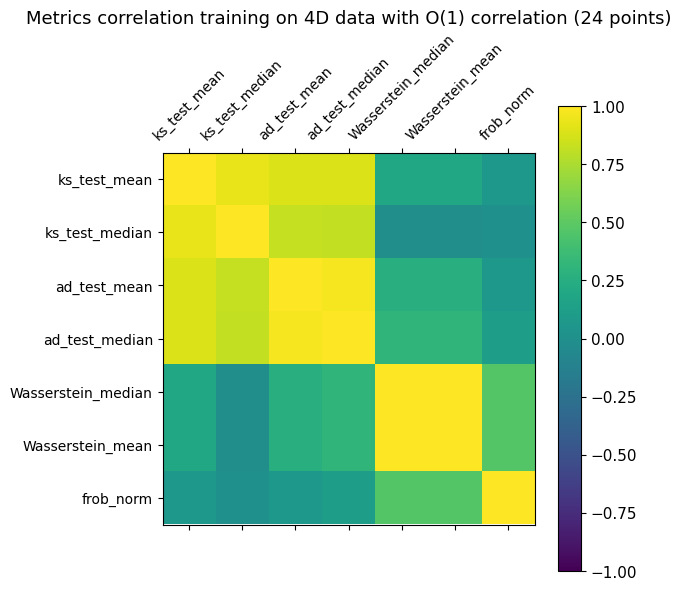

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


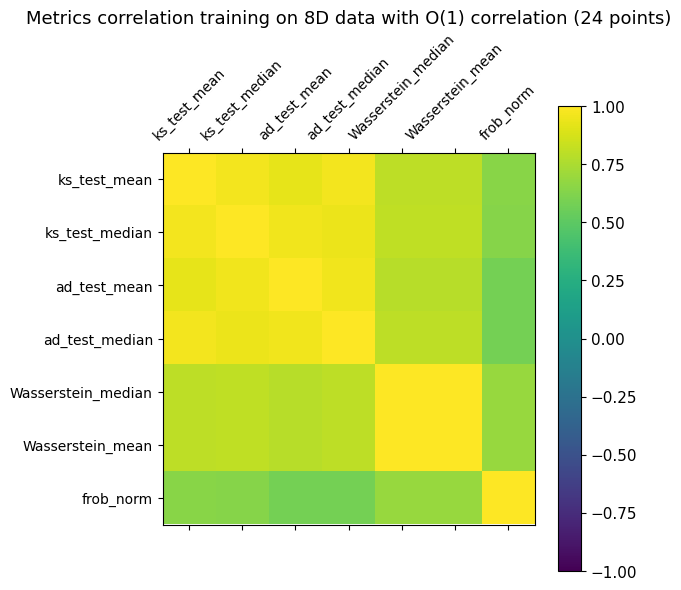

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


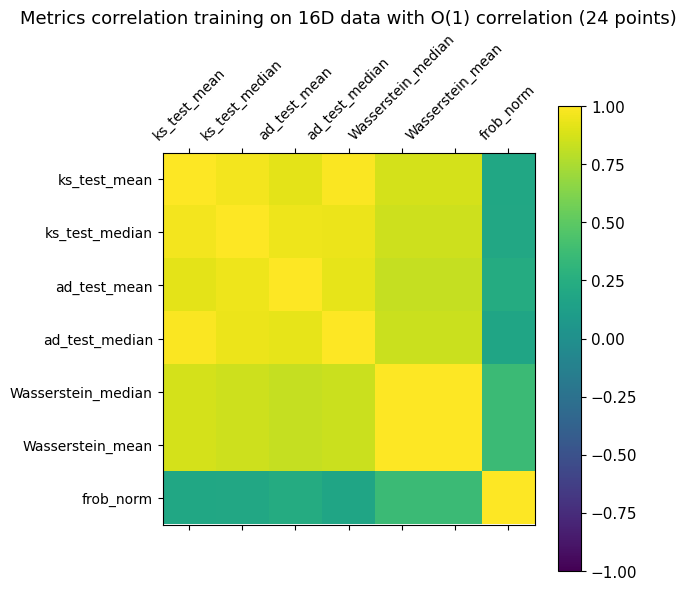

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


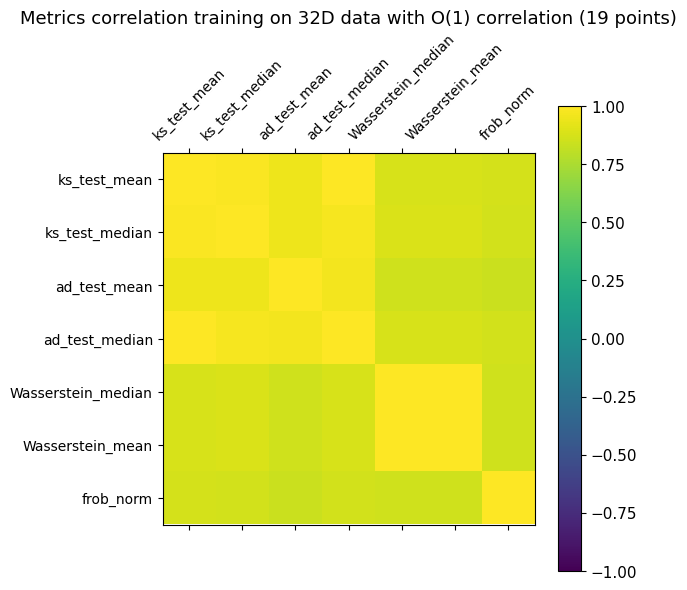

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


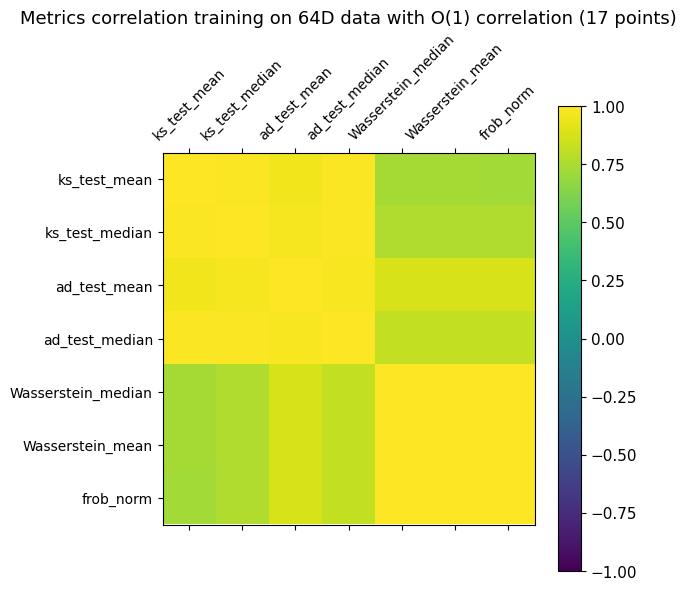

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


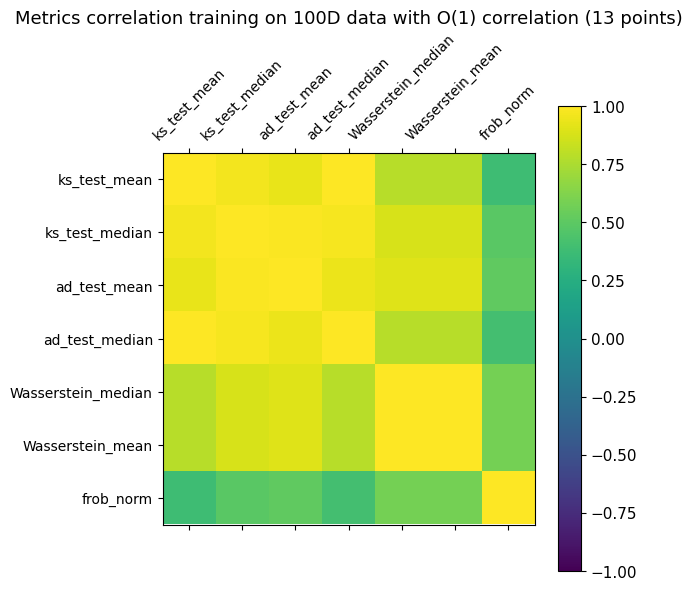

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


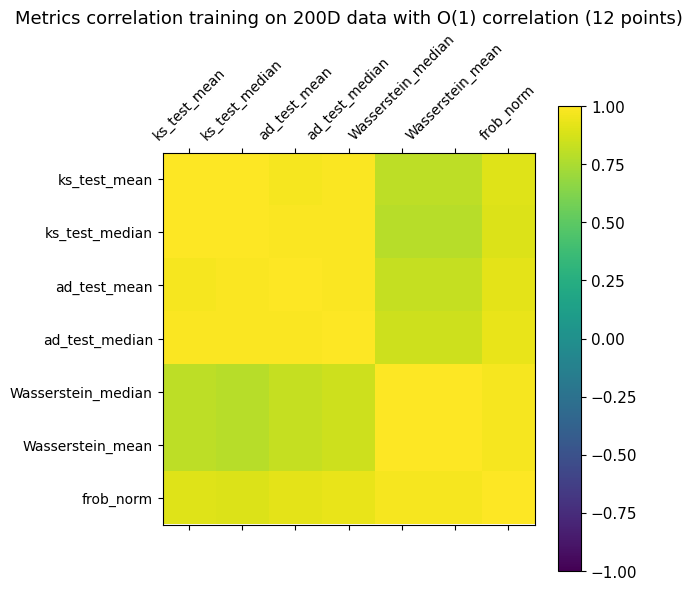

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


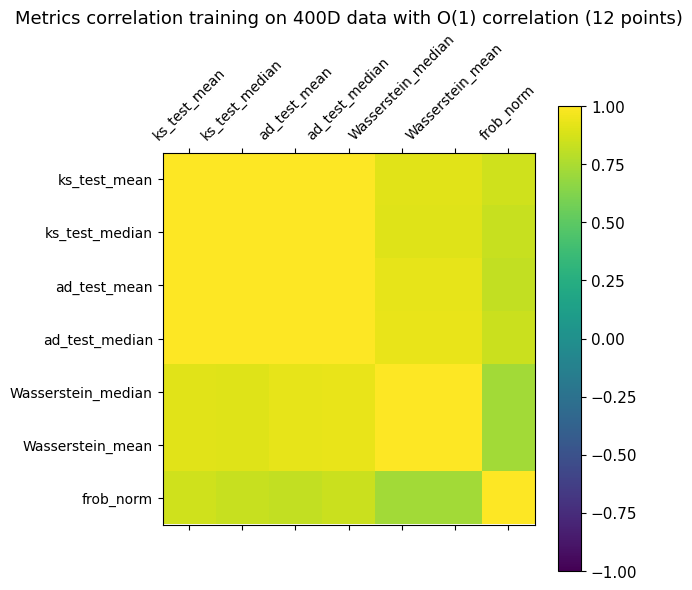

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


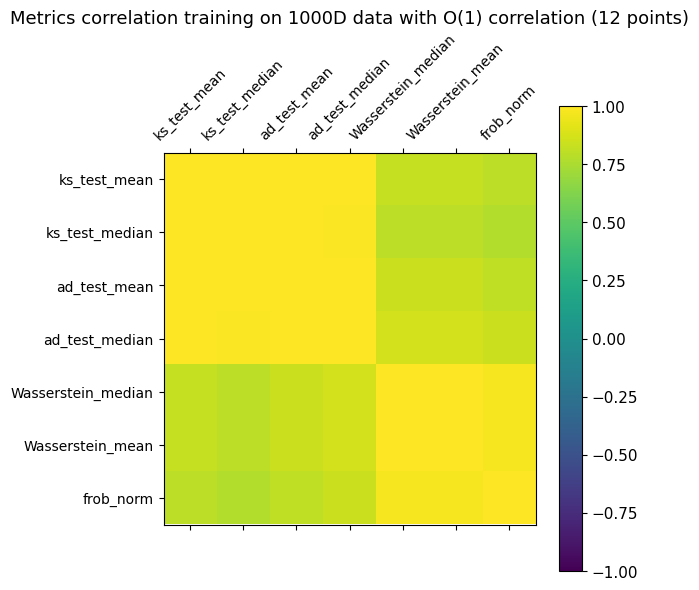

In [19]:
styles = [dict(selector="caption",
            props=[("text-align", "center"),
                   ("font-size", "150%"),
                   ("color", 'lime')])]
metrics = ["ks_test_mean", "ks_test_median","ad_test_mean", "ad_test_median","Wasserstein_median", "Wasserstein_mean","frob_norm"]
for d in [4,8,16,32,64,100,200,400,1000]:
    df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]
    df=df.astype(float)
    n_points=len(df)
    df['Wasserstein_median'] = df['Wasserstein_median'].apply(lambda x: -x)
    df['Wasserstein_mean'] = df['Wasserstein_mean'].apply(lambda x: -x)
    df['frob_norm'] = df['frob_norm'].apply(lambda x: -x)
    #display(df)
    title = "Metrics correlation training on "+str(d)+"D data with O(1) correlation ("+str(n_points)+" points)"
    corr=df.corr()
    display(corr.style.set_caption(title).set_table_styles(styles))
    jtplot.reset()
    f = plt.figure(figsize=(6, 6))
    plt.matshow(corr, fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), metrics, fontsize=10, rotation=45)
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), metrics, fontsize=10)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=11)
    plt.clim(-1, 1) 
    plt.title(title, fontsize=13)
    plt.show()
    plt.close()
    del(df)

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


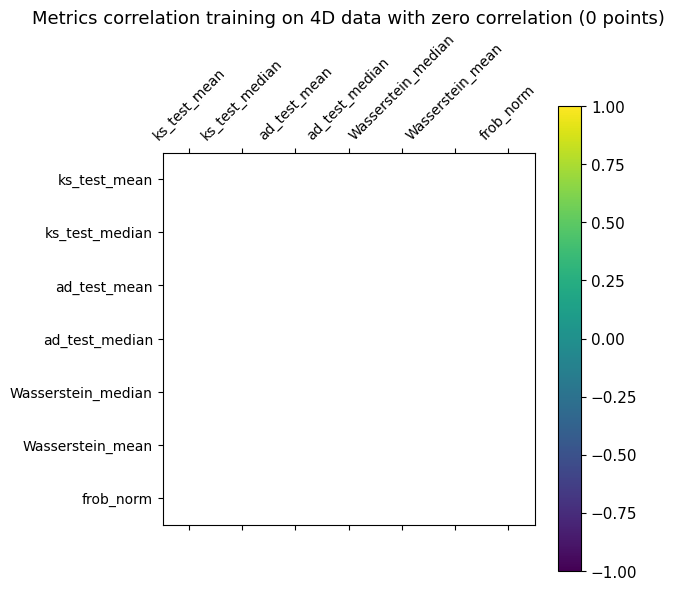

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


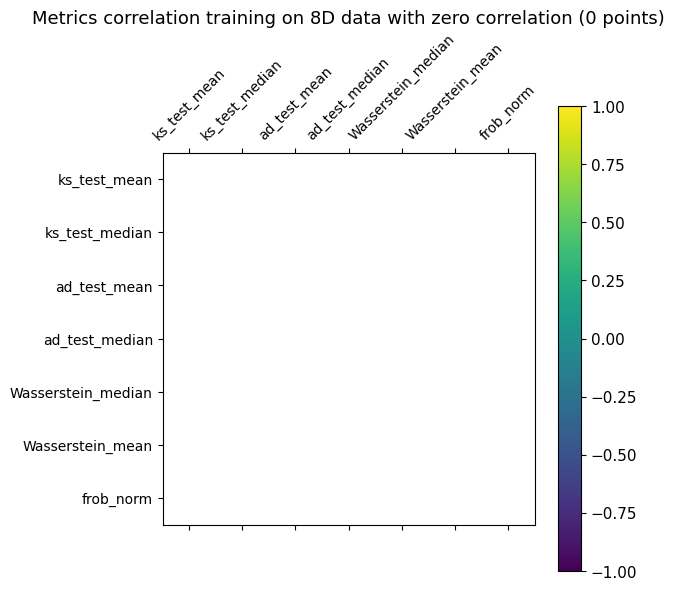

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


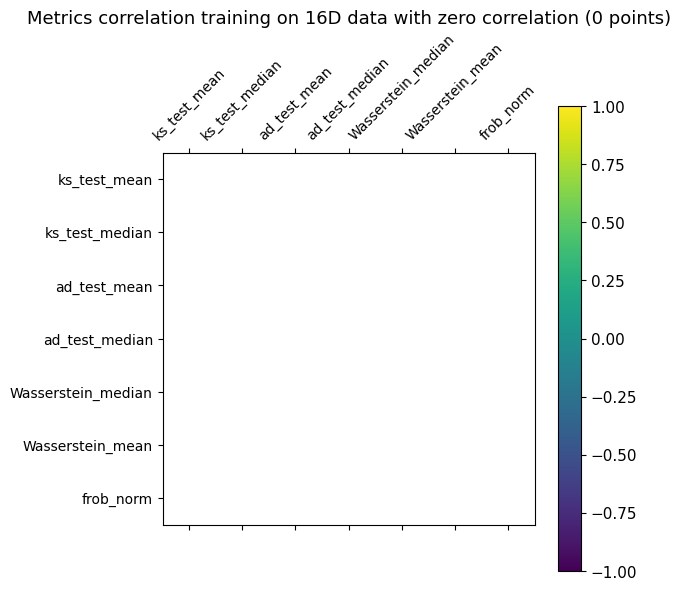

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


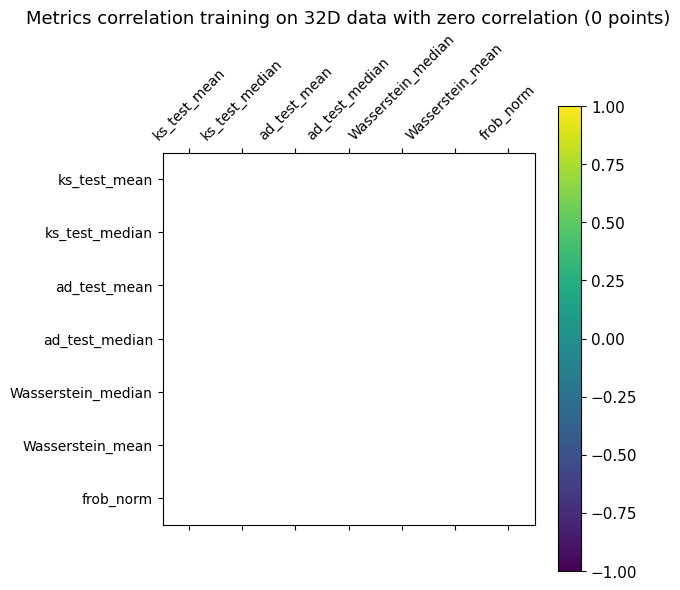

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


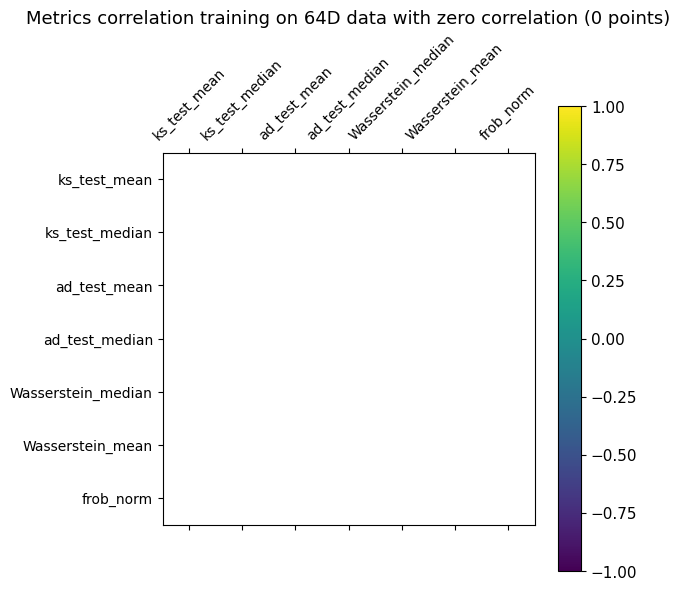

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


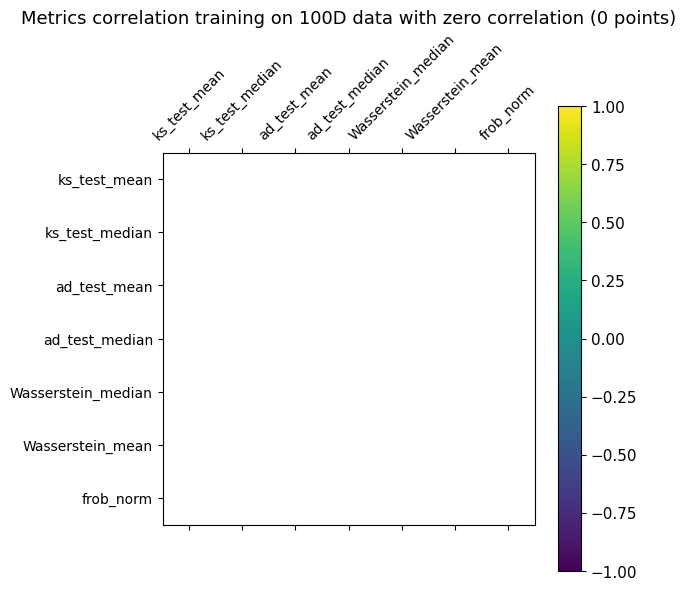

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


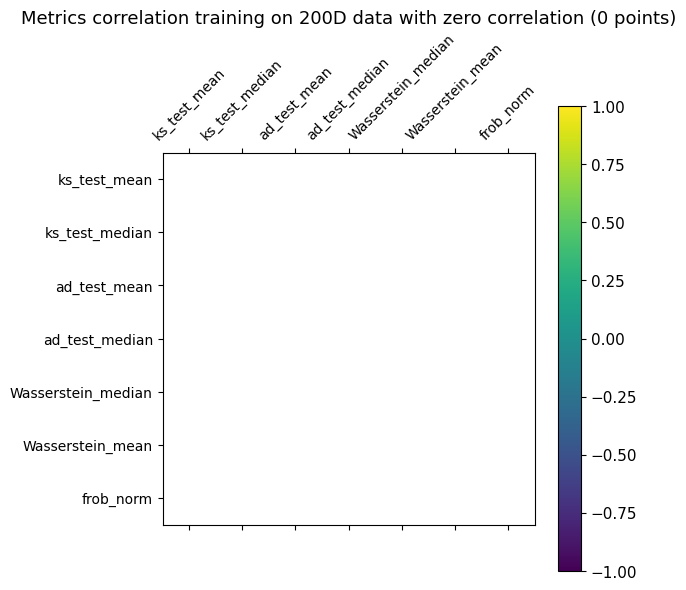

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


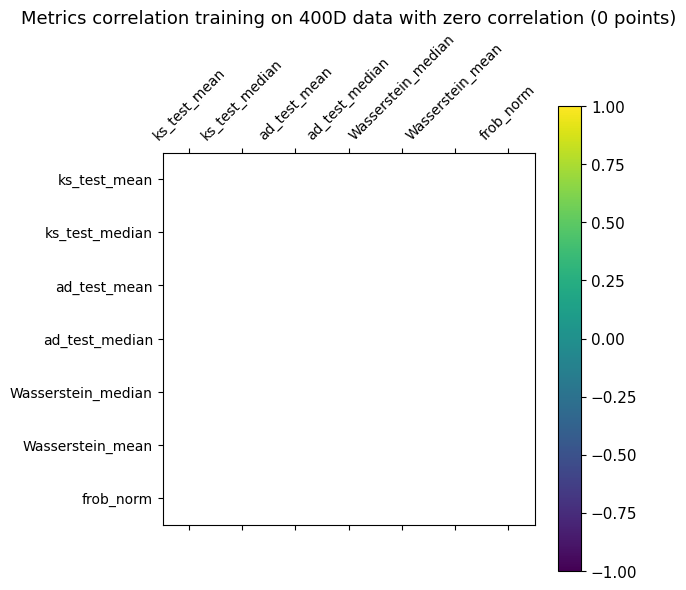

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


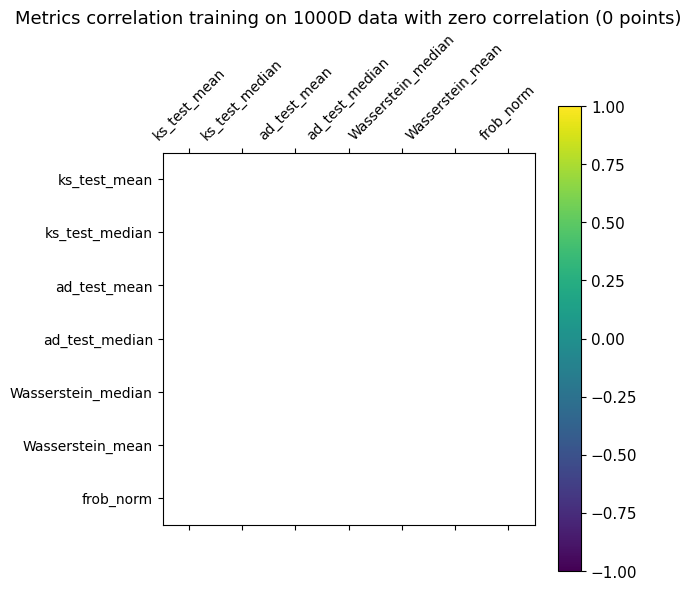

In [20]:
styles = [dict(selector="caption",
            props=[("text-align", "center"),
                   ("font-size", "150%"),
                   ("color", 'lime')])]
metrics = ["ks_test_mean", "ks_test_median","ad_test_mean", "ad_test_median","Wasserstein_median", "Wasserstein_mean","frob_norm"]
for d in [4,8,16,32,64,100,200,400,1000]:
    df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]
    df=df.astype(float)
    n_points=len(df)
    df['Wasserstein_median'] = df['Wasserstein_median'].apply(lambda x: -x)
    df['Wasserstein_mean'] = df['Wasserstein_mean'].apply(lambda x: -x)
    df['frob_norm'] = df['frob_norm'].apply(lambda x: -x)
    #display(df)
    title = "Metrics correlation training on "+str(d)+"D data with zero correlation ("+str(n_points)+" points)"
    corr=df.corr()
    display(corr.style.set_caption(title).set_table_styles(styles))
    jtplot.reset()
    f = plt.figure(figsize=(6, 6))
    plt.matshow(corr, fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), metrics, fontsize=10, rotation=45)
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), metrics, fontsize=10)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=11)
    plt.clim(-1, 1) 
    plt.title(title, fontsize=13)
    plt.show()
    plt.close()
    del(df)

## Results for different dimensions and metrics

In [36]:
ascending=True
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', None)
df_reduced_sorted = {}
df_reduced_unc = {}
df_best_corr = {}
ndims_list = [4,8,16,32,64,100,200,400,1000]
sort_metrics_list = ["swd_mean","ks_mean"]
for sort_metric in sort_metrics_list:
    print("Processing",sort_metric,"metric")
    df_reduced_sorted[sort_metric] = {}
    df_reduced_unc[sort_metric] = {}
    df_best_corr[sort_metric] = {}
    for ndims in ndims_list:
        print("... in",ndims,"D")
        df_reduced = df_correlated[df_correlated["ndims"]==ndims]
        #df_reduced.pop("Wasserstein_median")
        #df_reduced.pop("Wasserstein_mean")
        df_reduced_unc[sort_metric][ndims] = df_correlated_unc[df_correlated_unc["ndims"]==ndims]
        #df_reduced_unc[sort_metric][ndims].pop("Wasserstein_median")
        #df_reduced_unc[sort_metric][ndims].pop("Wasserstein_mean")
        df_reduced[sort_metric] = df_reduced[sort_metric].astype(float)
        df_reduced_sorted[sort_metric][ndims] = df_reduced.sort_values(by=sort_metric,axis=0,ascending=ascending).reset_index(drop=True)
        #left_aligned_df = df_reduced_sorted.style.set_properties(**{'text-align': 'left'}).set_properties(**{'background-color': 'green'}, subset=[sort_metric])
        #display(left_aligned_df)
        bests = []
        df = df_reduced_sorted[sort_metric][ndims]
        df_unc = df_reduced_unc[sort_metric][ndims]
        for bijector in ["MAFN","RealNVPN","MsplineN","CsplineN"]:
            tmp_best=df[df["bijector"]==bijector][df["correlation"]=="corr"].drop_duplicates('bijector')
            tmp_best["nruns"] = int(len(df_unc[df_unc["bijector"]==bijector][df_unc["correlation"]=="corr"][sort_metric]))
            tmp_best[sort_metric+"_mean"] = np.mean(df_unc[df_unc["bijector"]==bijector][df_unc["correlation"]=="corr"][sort_metric])
            tmp_best[sort_metric+"_std"] = np.std(df_unc[df_unc["bijector"]==bijector][df_unc["correlation"]=="corr"][sort_metric])
            bests.append(tmp_best)
        df_best=pd.concat(bests).sort_values(by=sort_metric,axis=0,ascending=ascending)
        column_to_move = df_best.pop(sort_metric+"_mean")
        pos_to_move = df_best.columns.get_loc(sort_metric)+2
        df_best.insert(pos_to_move, sort_metric+"_mean", column_to_move)
        column_to_move = df_best.pop(sort_metric+"_std")
        pos_to_move = pos_to_move+1
        df_best.insert(pos_to_move, sort_metric+"_std", column_to_move)
        column_to_move = df_best.pop("nruns")
        pos_to_move = pos_to_move+1
        df_best.insert(pos_to_move, "nruns", column_to_move)
        #df_best.pop("Wasserstein_median")
        #df_best.pop("Wasserstein_mean")
        df_best_corr[sort_metric][ndims] = df_best
        #left_aligned_df = df_best.style.set_properties(**{'text-align': 'left'}).set_properties(**{'background-color': 'green'}, subset=[sort_metric])
        ##display(left_aligned_df)

Processing swd_mean metric
... in 4 D
... in 8 D
... in 16 D
... in 32 D
... in 64 D
... in 100 D
... in 200 D


/tmp/ipykernel_9289/563619531.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced[sort_metric] = df_reduced[sort_metric].astype(float)
/tmp/ipykernel_9289/563619531.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp_best=df[df["bijector"]==bijector][df["correlation"]=="corr"].drop_duplicates('bijector')
/tmp/ipykernel_9289/563619531.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp_best["nruns"] = int(len(df_unc[df_unc["bijector"]==bijector][df_unc["correlation"]=="corr"][sort_metric]))
/tmp/ipykernel_9289/563619531.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp_best[sort_metric+"_mean"] = np.mean(df_unc[df_unc["bijec

... in 400 D
... in 1000 D
Processing ks_mean metric
... in 4 D
... in 8 D
... in 16 D


/tmp/ipykernel_9289/563619531.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced[sort_metric] = df_reduced[sort_metric].astype(float)
/tmp/ipykernel_9289/563619531.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp_best=df[df["bijector"]==bijector][df["correlation"]=="corr"].drop_duplicates('bijector')
/tmp/ipykernel_9289/563619531.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp_best["nruns"] = int(len(df_unc[df_unc["bijector"]==bijector][df_unc["correlation"]=="corr"][sort_metric]))
/tmp/ipykernel_9289/563619531.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp_best[sort_metric+"_mean"] = np.mean(df_unc[df_unc["bijec

... in 32 D
... in 64 D
... in 100 D
... in 200 D
... in 400 D
... in 1000 D


/tmp/ipykernel_9289/563619531.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp_best=df[df["bijector"]==bijector][df["correlation"]=="corr"].drop_duplicates('bijector')
/tmp/ipykernel_9289/563619531.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp_best["nruns"] = int(len(df_unc[df_unc["bijector"]==bijector][df_unc["correlation"]=="corr"][sort_metric]))
/tmp/ipykernel_9289/563619531.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp_best[sort_metric+"_mean"] = np.mean(df_unc[df_unc["bijector"]==bijector][df_unc["correlation"]=="corr"][sort_metric])
/tmp/ipykernel_9289/563619531.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp_best[sort_metric+"_std"] = np.std(df_unc[df_unc["bijector"]==bijector][df_unc["correlation"]=="corr"][sort_metric])
/tmp/ipykernel_9289/563619531.py:30: UserWarning: Boolean Series key will be reindexed to matc

In [26]:
sort_metrics_list = ["sliced_Wasserstein_mean","ks_test_median"]

In [ ]:
df_reduced.sort_values(by=sort_metric,axis=0,ascending=ascending).reset_index(drop=True)

In [37]:
ndims=4
sort_metric="swd_mean"
#sort_metric="run_n"
ascending=True
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_tmp = df_reduced_sorted["swd_mean"][ndims]
df_tmp = df_tmp[df_tmp["bijector"]=="MAFN"]
left_aligned_df = df_tmp.style.set_properties(**{'text-align': 'left'}).set_properties(**{'background-color': 'green'}, subset=[sort_metric])
display(left_aligned_df)

In [20]:
df_result=pd.DataFrame()
sort_metric="swd_mean"
#sort_metric="ks_test_median"
ascending=True
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
for i in [1,2,3,4]:
    tmp = recompute_metrics(run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_"+str(i)+"/results.txt")
    df_result= pd.concat([df_result,tmp])
#left_aligned_df = df_result.style.set_properties(**{'text-align': 'left'}).set_properties(**{'background-color': 'green'}, subset=[sort_metric])
#display(left_aligned_df)
display(df_result)

Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


[0.032620666980743424, 0.08291252446174621, 0.03772835922241212, 0.07791515874862671, 0.09659262466430668, 0.08506637370586395, 0.11112226283550264, 0.06967371964454651, 0.08844845032691957, 0.07061071288585663, 0.061942330479621874, 0.05440192317962647, 0.13789797782897956, 0.0615240124464035, 0.12085604238510131, 0.1472591242790222, 0.04459415507316592, 0.07707343077659608, 0.06338093721866608, 0.1000870268344879, 0.1322427949905396, 0.06795618712902068, 0.09049561190605165, 0.11514270281791686, 0.11472248601913455, 0.10885986888408661, 0.13339121103286747, 0.166237583398819, 0.07167986631393435, 0.06777105534076691, 0.05760729455947875, 0.12608986020088192, 0.029191527843475337, 0.05032698392868043, 0.056645456671714785, 0.07525036120414734, 0.03149152326583862, 0.07271340143680573, 0.058081361770629905, 0.06726170492172243, 0.07222702217102056, 0.06305700075626375, 0.03853258061408997, 0.06715877389907837, 0.053063489913940456, 0.05526920711994171, 0.04710677564144132, 0.0566781890

Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_1/ computed and saved in 4.713712382999802 s.
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_2/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


[0.02426959609985352, 0.08521134078502654, 0.0375806188583374, 0.04759635090827942, 0.08023498439788823, 0.10543845438957214, 0.09252638709545136, 0.04976093578338623, 0.05157515597343447, 0.04465098333358765, 0.06484540307521817, 0.1039182949066162, 0.10743408203125003, 0.06886213552951813, 0.1087994966506958, 0.13745757913589476, 0.13068413949012764, 0.06885531878471375, 0.10534445154666904, 0.06973235297203065, 0.08781284856796266, 0.07848672783374787, 0.07744397890567782, 0.05140275526046753, 0.1368190016746522, 0.1537306374311447, 0.12755724287033082, 0.11323706626892091, 0.05736135196685792, 0.06354318797588349, 0.04858595609664916, 0.09589393663406373, 0.06692949104309087, 0.0496702516078949, 0.06794630372524263, 0.09963168478012085, 0.04279931688308718, 0.050547838091850275, 0.06617201554775239, 0.06777258253097534, 0.05984793710708622, 0.0796239857673645, 0.040749623298645024, 0.09819641327857971, 0.06959396457672122, 0.054743515491485595, 0.04474975979328154, 0.10042689561843

Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_2/ computed and saved in 4.534904878999441 s.
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_3/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


[0.03428236150741577, 0.09879018580913543, 0.044630856990814205, 0.07124893999099732, 0.03421151614189148, 0.06417658686637878, 0.041028617978096024, 0.05426878976821901, 0.07112717652320866, 0.06863100922107697, 0.07959072303771972, 0.11866891527175902, 0.16550657320022588, 0.14744054901599887, 0.08749171900749207, 0.07958699178695677, 0.03373907494544982, 0.03693062806129456, 0.041589777827262885, 0.061862050771713264, 0.09019029045104984, 0.08271823048591614, 0.0854016206264496, 0.10915346455574033, 0.0980944976806641, 0.06437270963191986, 0.0788124022483826, 0.0993355815410614, 0.032741900444030775, 0.11109494566917419, 0.049410174608230606, 0.06435254645347596, 0.02905901098251344, 0.04991193926334381, 0.06822290360927581, 0.06819963741302489, 0.09382406616210935, 0.07169520926475526, 0.09494831001758577, 0.07806019067764283, 0.08235893154144291, 0.10917339134216308, 0.037048733234405516, 0.06309935903549194, 0.14272347807884223, 0.10510761070251465, 0.13190175998210907, 0.1303998

Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_3/ computed and saved in 4.539971554000658 s.
Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_4/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


[0.15708366656303413, 0.14624964046478273, 0.09298794889450077, 0.1008891007900238, 0.18204994487762458, 0.12786482465267182, 0.1195054055452347, 0.09900251030921936, 0.07083538174629217, 0.07794062614440919, 0.06682503914833068, 0.06839861249923707, 0.23080104255676281, 0.10936010324954987, 0.14469353961944584, 0.11897560620307922, 0.04743997812271118, 0.04806621128320694, 0.0387535446882248, 0.07233480715751647, 0.11269126510620123, 0.07449663031101228, 0.10316711950302127, 0.07786449646949767, 0.04790927696228029, 0.049157826066017166, 0.052010183334350577, 0.15652277541160584, 0.13244510245323188, 0.15063042151927947, 0.09526225352287296, 0.09271170473098755, 0.03655208683013916, 0.07799355387687684, 0.056149321913719186, 0.06674001002311707, 0.11589897537231436, 0.09425328946113586, 0.1153666309118271, 0.09952529597282411, 0.19758571839332595, 0.15121927106380462, 0.11536399507522588, 0.07281002879142762, 0.0470384273529053, 0.08795888864994048, 0.07815108740329743, 0.049536518335

Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_4/ computed and saved in 4.725101668000207 s.


run_n  run_seed  ndims  nsamples correlation  nbijectors bijector  \
0      1         0      4    100000        corr           5     MAFN   
0      2         0      4    100000        corr           5     MAFN   
0      3         0      4    100000        corr          10     MAFN   
0      4         0      4    100000        corr          10     MAFN   

  activation  spline_knots  range_min  eps_regulariser regulariser   ks_mean  \
0       relu             8         -5                0        None  0.479285   
0       relu             8         -5                0        None  0.504421   
0       relu             8         -5                0        None  0.510273   
0       relu             8         -5                0        None  0.442665   

     ks_std   ad_mean    ad_std   wd_mean    wd_std  swd_mean   swd_std  \
0  0.295250  0.210818  0.072579  0.079048  0.033835  0.077915  0.038284   
0  0.284632  0.221983  0.059968  0.079995  0.033329  0.079717  0.039971   
0  0.288716  0.218617  0.063455  0.080910  0.036001  0.080013  0.041611   
0  0.295300  0.194875  0.082358  0.092215  0.043582  0.089042  0.050943   

    fn_mean    fn_std hidden_layers  batch_size  epochs_input  epochs_output  \
0  0.086389  0.049542   128-128-128         512          1000            323   
0  0.087743  0.040154   256-256-256         512          1000            361   
0  0.086235  0.046316   128-128-128         512          1000            288   
0  0.104770  0.063823   256-256-256         512          1000            202   

          time  
0   745.240984  
0   833.398603  
0  1834.018883  
0   901.423236

In [101]:
from scipy.stats import wasserstein_distance
def Wasserstein_distance_old(target_test_data,nf_dist,norm=True):
    print("\nWasserstein_distance_old function")
    ##create data sample from trained normising flow
    #z=base_dist.sample((target_test_data.shape[0]))
    #x_estimated=nf_dist.bijector.forward(z).numpy()
    if norm==False:
        x_estimated=nf_dist.sample(target_test_data.shape[0])
        x_estimated=np.reshape(x_estimated,newshape=target_test_data.shape)
    else:
        x_estimated=nf_dist
    wasserstein_distances=[]
    for dim in range(target_test_data.shape[1]):
        #print(wasserstein_distance(x_target[:,dim], x_estimated[:,dim]))
        ws_distance=wasserstein_distance(target_test_data[:,dim], x_estimated[:,dim])
        wasserstein_distances.append(ws_distance)
    wd_mean = np.mean(wasserstein_distances)
    wd_std = np.std(wasserstein_distances)
    print(len(wasserstein_distances),"WD tests performed with",[len(target_test_data),len(x_estimated)],"dimensional samples.")
    print("WD Mean =",wd_mean)
    print("WD Std =",wd_std)
    #print("Samples =\n",wasserstein_distances)
    return [wd_mean,wd_std]

def sliced_Wasserstein_distance_old(target_test_data, nf_dist, norm=True, n_slices=None, seed=None):
    """
    Compute the sliced Wasserstein distance between two sets of points
    using n_slices random directions and the p-th Wasserstein distance.
    """
    print("\nsliced_Wasserstein_distance_old function")
    if seed is None:
        np.random.seed(np.random.randint(10e6))
    else:
        np.random.seed(int(seed))
    if n_slices is None:
        n_slices = target_test_data.shape[1]
    else:
        n_slices = int(n_slices)
    if norm==False:
        x_estimated=nf_dist.sample(target_test_data.shape[0])
        x_estimated=np.reshape(x_estimated,newshape=target_test_data.shape)
    else:
        x_estimated=nf_dist
    # Generate random directions
    directions = np.random.randn(n_slices, target_test_data.shape[1])
    directions /= np.linalg.norm(directions, axis=1)[:, None]
    # Compute sliced Wasserstein distance
    ws_distances = []
    for direction in directions:
        target_proj = target_test_data @ direction
        estimated_proj = x_estimated @ direction
        ws_distances.append(wasserstein_distance(target_proj, estimated_proj))
    swd_mean = np.mean(ws_distances)
    swd_std = np.std(ws_distances)
    print(len(ws_distances),"SWD tests performed with",[len(target_test_data),len(x_estimated)],"dimensional samples.")
    print("SWD Mean =",swd_mean)
    print("SWD Std =",swd_std)
    #print("Samples =\n",wasserstein_distances)
    return [swd_mean,swd_std]

def WD(dist_1,dist_2,n_iter=100,batch_size=100000):
    """
    The Wasserstein distance between the target distribution and the distribution of the test data.
    The test is performed for each dimension of the distributions and the mean and std of the p-values are returned. 
    _summary_

    Args:
        dist_1 (numpy array or distribution): The first distribution to be compared
        dist_2 (numpy array or distribution): The second distribution to be compared
        n_iter (int, optional): Number of iterations to be performed. Defaults to 100.
        batch_size (int, optional): Number of samples to be used in each iteration. Only used if num is true. Defaults to 100000.

    Returns:
        [float,float]: Mean and std of the p-values obtained from the KS tests
    """
    print("\nWD function")
    # If an array of the input is an array, then the input batch_size is ignored and batch_size is set to nsamples/n_iter
    if isinstance(dist_1, np.ndarray):
        ndims=dist_1.shape[1]
        nsamples=dist_1.shape[0]
        batch_size=int(nsamples/n_iter)
    elif isinstance(dist_2, np.ndarray):
        ndims=dist_2.shape[1]
        nsamples=dist_2.shape[0]
        batch_size=int(nsamples/n_iter)
    else:
        ndims=dist_1.sample(2).numpy().shape[1]
    # Define ad_list that will contain the list of wd for all dimensions and all iterations
    wd_list=[]
    # Loop over all iterations
    for k in range(n_iter):
        # If num is true, then the samples are split in n_iter batches of size nsamples/n_iter, otherwise we just sample batch_size points from the distributions
        if isinstance(dist_1, np.ndarray):
            dist_1_k=dist_1[k*batch_size:(k+1)*batch_size,:]
        elif isinstance(dist_1, tfd.distribution.Distribution):
            dist_1_k=dist_1.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        if isinstance(dist_2, np.ndarray):
            dist_2_k=dist_2[k*batch_size:(k+1)*batch_size,:]
        elif isinstance(dist_2, tfd.distribution.Distribution):
            dist_2_k=dist_2.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        # The WD test is computed and saved for each dimension
        for dim in range(ndims):
            wd=wasserstein_distance(dist_1_k[:,dim], dist_2_k[:,dim])
            wd_list.append(wd)
    #print(wd_list)
    # Compute the mean and std of the p-values
    wd_mean = np.mean(wd_list)
    wd_std = np.std(wd_list)
    print(len(wd_list),"WD tests performed with",[len(dist_1_k),len(dist_2_k)],"dimensional samples.")
    print("WD Mean =",wd_mean)
    print("WD Std =",wd_std)
    #print("Samples =\n",wd_list)
    # Return the mean and std of the p-values
    #return wd_list
    return [wd_mean,wd_std]

def SWD(dist_1,dist_2,n_iter=100,batch_size=100000,n_slices=100,seed=None):
    """
    Compute the sliced Wasserstein distance between two sets of points
    using n_slices random directions and the p-th Wasserstein distance.
    The test is performed for each dimension of the distributions and the mean and std of the p-values are returned. 
    _summary_

    Args:
        dist_1 (numpy array or distribution): The first distribution to be compared
        dist_2 (numpy array or distribution): The second distribution to be compared
        n_iter (int, optional): Number of iterations to be performed. Defaults to 100.
        batch_size (int, optional): Number of samples to be used in each iteration. Only used if num is true. Defaults to 100000.

    Returns:
        [float,float]: Mean and std of the p-values obtained from the KS tests
    """
    print("\nSWD function")
    # If an array of the input is an array, then the input batch_size is ignored and batch_size is set to nsamples/n_iter
    if isinstance(dist_1, np.ndarray):
        ndims=dist_1.shape[1]
        nsamples=dist_1.shape[0]
        batch_size=int(nsamples/n_iter)
    elif isinstance(dist_2, np.ndarray):
        ndims=dist_2.shape[1]
        nsamples=dist_2.shape[0]
        batch_size=int(nsamples/n_iter)
    else:
        ndims=dist_1.sample(2).numpy().shape[1]
    if seed is None:
        np.random.seed(np.random.randint(1000000))
    else:
        np.random.seed(int(seed))
    if n_slices is None:
        n_slices = np.max([100,ndims])
    else:
        n_slices = int(n_slices)
    # Define ad_list that will contain the list of swd for all dimensions and all iterations
    swd_list=[]
    # Loop over all iterations
    for k in range(n_iter):
        # If num is true, then the samples are split in n_iter batches of size nsamples/n_iter, otherwise we just sample batch_size points from the distributions
        if isinstance(dist_1, np.ndarray):
            dist_1_k=dist_1[k*batch_size:(k+1)*batch_size,:]
        elif isinstance(dist_1, tfd.distribution.Distribution):
            dist_1_k=dist_1.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        if isinstance(dist_2, np.ndarray):
            dist_2_k=dist_2[k*batch_size:(k+1)*batch_size,:]
        elif isinstance(dist_2, tfd.distribution.Distribution):
            dist_2_k=dist_2.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        # Generate random directions
        directions = np.random.randn(n_slices, ndims)
        directions /= np.linalg.norm(directions, axis=1)[:, None]
        # Compute sliced Wasserstein distance
        for direction in directions:
            dist_1_proj = dist_1_k @ direction
            dist_2_proj = dist_2_k @ direction
            swd_list.append(wasserstein_distance(dist_1_proj, dist_2_proj))
    # Compute the mean and std of the p-values
    swd_mean = np.mean(swd_list)
    swd_std = np.std(swd_list)
    print(len(swd_list),"WD tests performed with",[len(dist_1_k),len(dist_2_k)],"dimensional samples.")
    print("WD Mean =",swd_mean)
    print("WD Std =",swd_std)
    return [swd_mean,swd_std]
    
def WD_new(dist_1,dist_2,n_iter=100,batch_size=100000):
    """
    The Wasserstein distance between the target distribution and the distribution of the test data.
    The test is performed for each dimension of the distributions and the mean and std of the p-values are returned. 
    _summary_

    Args:
        dist_1 (numpy array or distribution): The first distribution to be compared
        dist_2 (numpy array or distribution): The second distribution to be compared
        n_iter (int, optional): Number of iterations to be performed. Defaults to 100.
        batch_size (int, optional): Number of samples to be used in each iteration. Only used if num is true. Defaults to 100000.

    Returns:
        [float,float]: Mean and std of the p-values obtained from the KS tests
    """
    print("\nWD_new function")
    # If an array of the input is an array, then the input batch_size is ignored and batch_size is set to nsamples/n_iter
    n_iter=int(np.ceil(np.sqrt(n_iter)))
    if isinstance(dist_1, np.ndarray):
        ndims=dist_1.shape[1]
        nsamples=dist_1.shape[0]
        batch_size=int(nsamples/n_iter)
    elif isinstance(dist_2, np.ndarray):
        ndims=dist_2.shape[1]
        nsamples=dist_2.shape[0]
        batch_size=int(nsamples/n_iter)
    else:
        ndims=dist_1.sample(2).numpy().shape[1]
    # Define ad_list that will contain the list of wd for all dimensions and all iterations
    wd_list=[]
    # Loop over all iterations
    for j in range(n_iter):
        # If num is true, then the samples are split in n_iter batches of size nsamples/n_iter, otherwise we just sample batch_size points from the distributions
        if isinstance(dist_1, np.ndarray):
            dist_1_j=dist_1[j*batch_size:(j+1)*batch_size,:]
        elif isinstance(dist_1, tfd.distribution.Distribution):
            dist_1_j=dist_1.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        for k in range(n_iter):
            if isinstance(dist_2, np.ndarray):
                dist_2_k=dist_2[k*batch_size:(k+1)*batch_size,:]
            elif isinstance(dist_2, tfd.distribution.Distribution):
                dist_2_k=dist_2.sample(batch_size).numpy()
            else:   
                raise ValueError("dist_1 must be either a numpy array or a distribution")
            # The WD test is computed and saved for each dimension
            for dim in range(ndims):
                wd=wasserstein_distance(dist_1_j[:,dim], dist_2_k[:,dim])
                wd_list.append(wd)
    #print(wd_list)
    # Compute the mean and std of the p-values
    wd_mean = np.mean(wd_list)
    wd_std = np.std(wd_list)
    print(len(wd_list),"WD tests performed with",[len(dist_1_j),len(dist_2_k)],"dimensional samples.")
    print("WD Mean =",wd_mean)
    print("WD Std =",wd_std)
    #print("Samples =\n",wd_list)
    # Return the mean and std of the p-values
    #return wd_list
    return [wd_mean,wd_std]

def SWD_new(dist_1,dist_2,n_iter=100,batch_size=100000,n_slices=100,seed=None):
    """
    Compute the sliced Wasserstein distance between two sets of points
    using n_slices random directions and the p-th Wasserstein distance.
    The test is performed for each dimension of the distributions and the mean and std of the p-values are returned. 
    _summary_

    Args:
        dist_1 (numpy array or distribution): The first distribution to be compared
        dist_2 (numpy array or distribution): The second distribution to be compared
        n_iter (int, optional): Number of iterations to be performed. Defaults to 100.
        batch_size (int, optional): Number of samples to be used in each iteration. Only used if num is true. Defaults to 100000.

    Returns:
        [float,float]: Mean and std of the p-values obtained from the KS tests
    """
    print("\nSWD_new function")
    # If an array of the input is an array, then the input batch_size is ignored and batch_size is set to nsamples/n_iter
    n_iter=int(np.ceil(np.sqrt(n_iter)))
    if isinstance(dist_1, np.ndarray):
        ndims=dist_1.shape[1]
        nsamples=dist_1.shape[0]
        batch_size=int(nsamples/n_iter)
    elif isinstance(dist_2, np.ndarray):
        ndims=dist_2.shape[1]
        nsamples=dist_2.shape[0]
        batch_size=int(nsamples/n_iter)
    else:
        ndims=dist_1.sample(2).numpy().shape[1]
    if seed is None:
        np.random.seed(np.random.randint(1000000))
    else:
        np.random.seed(int(seed))
    if n_slices is None:
        n_slices = np.max([100,ndims])
    else:
        n_slices = int(n_slices)
    # Define ad_list that will contain the list of swd for all dimensions and all iterations
    swd_list=[]
    # Loop over all iterations
    for j in range(n_iter):
        # If num is true, then the samples are split in n_iter batches of size nsamples/n_iter, otherwise we just sample batch_size points from the distributions
        if isinstance(dist_1, np.ndarray):
            dist_1_j=dist_1[j*batch_size:(j+1)*batch_size,:]
        elif isinstance(dist_1, tfd.distribution.Distribution):
            dist_1_j=dist_1.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        for k in range(n_iter):
            if isinstance(dist_2, np.ndarray):
                dist_2_k=dist_2[k*batch_size:(k+1)*batch_size,:]
            elif isinstance(dist_2, tfd.distribution.Distribution):
                dist_2_k=dist_2.sample(batch_size).numpy()
            else:   
                raise ValueError("dist_1 must be either a numpy array or a distribution")
            # Generate random directions
            directions = np.random.randn(n_slices, ndims)
            directions /= np.linalg.norm(directions, axis=1)[:, None]
            # Compute sliced Wasserstein distance
            for direction in directions:
                dist_1_proj = dist_1_j @ direction
                dist_2_proj = dist_2_k @ direction
                swd_list.append(wasserstein_distance(dist_1_proj, dist_2_proj))
    # Compute the mean and std of the p-values
    swd_mean = np.mean(swd_list)
    swd_std = np.std(swd_list)
    print(len(swd_list),"WD tests performed with",[len(dist_1_j),len(dist_2_k)],"dimensional samples.")
    print("WD Mean =",swd_mean)
    print("WD Std =",swd_std)
    return [swd_mean,swd_std]

In [53]:
from scipy import stats
def KS_test_1(dist_1,dist_2,n_iter=10,batch_size=100000):
    """
    The Kolmogorov-Smirnov test is a non-parametric test that compares two distributions and returns a p-value that indicates whether the two distributions are the same or not. 
    The test is performed for each dimension of the distributions and for n_iter times and the mean and std of the p-values are returned.
    In the case of numerical distributions, data are split in n_iter batches dist_1_j, dist_2_j of size batch_size=int(nsamples/n_iter) and the mean and std are computed over all pairs of batches dist_1_j, dist_2_j.
    Args:
        dist_1 (numpy array or distribution): The first distribution to be compared
        dist_2 (numpy array or distribution): The second distribution to be compared
        n_iter (int, optional): Number of iterations to be performed. Defaults to 10.
        batch_size (int, optional): Number of samples to be used in each iteration. Only used if num is true. Defaults to 100000.
    Returns:
        [float,float]: Mean and std of the p-values obtained from the KS tests
    """
    print("\nKS_test_1 function")
    # If an array of the input is an array, then the input batch_size is ignored and batch_size is set to nsamples/n_iter
    if isinstance(dist_1, np.ndarray):
        ndims=dist_1.shape[1]
        nsamples=dist_1.shape[0]
        batch_size=int(nsamples/n_iter)
    elif isinstance(dist_2, np.ndarray):
        ndims=dist_2.shape[1]
        nsamples=dist_2.shape[0]
        batch_size=int(nsamples/n_iter)
    else:
        ndims=dist_1.sample(2).numpy().shape[1]
    # Define ks_list that will contain the list of ks for all dimensions and all iterations
    ks_list=[]
    # Loop over all iterations
    for k in range(n_iter):
        # If num is true, then the samples are split in n_iter batches of size nsamples/n_iter, otherwise we just sample batch_size points from the distributions
        if isinstance(dist_1, np.ndarray):
            dist_1_k=dist_1[k*batch_size:(k+1)*batch_size,:]
        elif isinstance(dist_1, tfd.distribution.Distribution):
            dist_1_k=dist_1.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        if isinstance(dist_2, np.ndarray):
            dist_2_k=dist_2[k*batch_size:(k+1)*batch_size,:]
        elif isinstance(dist_2, tfd.distribution.Distribution):
            dist_2_k=dist_2.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        # The ks test is computed and the p-value saved for each dimension
        for dim in range(ndims):
            p_val=stats.ks_2samp(dist_1_k[:,dim], dist_2_k[:,dim])[1]
            ks_list.append(p_val)
    # Compute the mean and std of the p-values
    ks_mean = np.mean(ks_list)
    ks_std = np.std(ks_list)
    print(len(ks_list),"KS tests performed with",[len(dist_1_k),len(dist_2_k)],"dimensional samples.")
    print("KS Mean =",ks_mean)
    print("KS Std =",ks_std)
    # Return the mean and std of the p-values
    return [ks_mean,ks_std]


def KS_test_2(dist_1,dist_2,n_iter=100,batch_size=100000):
    """
    The Kolmogorov-Smirnov test is a non-parametric test that compares two distributions and returns a p-value that indicates whether the two distributions are the same or not. 
    The test is performed for each dimension of the distributions and for n_iter times and the mean and std of the p-values are returned.
    In the case of numerical distributions, data are split in np.ceil(np.sqrt(n_iter)) batches dist_1_j, dist_2_k of size batch_size=int(nsamples/np.ceil(np.sqrt(n_iter))) and the mean and std are computed over all pairs of batches dist_1_j, dist_2_k.
    Args:
        dist_1 (numpy array or distribution): The first distribution to be compared
        dist_2 (numpy array or distribution): The second distribution to be compared
        n_iter (int, optional): Number of iterations to be performed. Defaults to 100.
        batch_size (int, optional): Number of samples to be used in each iteration. Only used if num is true. Defaults to 100000.
    Returns:
        [float,float]: Mean and std of the p-values obtained from the KS tests
    """
    print("\nKS_test_2 function")
    # If an array of the input is an array, then the input batch_size is ignored and batch_size is set to nsamples/n_iter
    n_iter=int(np.ceil(np.sqrt(n_iter)))
    if isinstance(dist_1, np.ndarray):
        ndims=dist_1.shape[1]
        nsamples=dist_1.shape[0]
        batch_size=int(nsamples/n_iter)
    elif isinstance(dist_2, np.ndarray):
        ndims=dist_2.shape[1]
        nsamples=dist_2.shape[0]
        batch_size=int(nsamples/n_iter)
    else:
        ndims=dist_1.sample(2).numpy().shape[1]
    # Define ks_list that will contain the list of ks for all dimensions and all iterations
    ks_list=[]
    # Loop over all iterations
    for j in range(n_iter):
        # If num is true, then the samples are split in n_iter batches of size nsamples/n_iter, otherwise we just sample batch_size points from the distributions
        if isinstance(dist_1, np.ndarray):
            dist_1_j=dist_1[j*batch_size:(j+1)*batch_size,:]
        elif isinstance(dist_1, tfd.distribution.Distribution):
            dist_1_j=dist_1.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        for k in range(n_iter):
            if isinstance(dist_2, np.ndarray):
                dist_2_k=dist_2[k*batch_size:(k+1)*batch_size,:]
            elif isinstance(dist_2, tfd.distribution.Distribution):
                dist_2_k=dist_2.sample(batch_size).numpy()
            else:   
                raise ValueError("dist_1 must be either a numpy array or a distribution")
            # The ks test is computed and the p-value saved for each dimension
            for dim in range(ndims):
                p_val=stats.ks_2samp(dist_1_j[:,dim], dist_2_k[:,dim])[1]
                ks_list.append(p_val)
    # Compute the mean and std of the p-values
    ks_mean = np.mean(ks_list)
    ks_std = np.std(ks_list)
    print(len(ks_list),"KS tests performed with",[len(dist_1_j),len(dist_2_k)],"dimensional samples.")
    print("KS Mean =",ks_mean)
    print("KS Std =",ks_std)
    # Return the mean and std of the p-values
    return [ks_mean,ks_std]


def KS_test_old(target_test_data,nf_dist,n_iter=100,norm=True):
    """Kolmogorov-Smirnov test between target distribution and trained normalising flow 
    Args:
        target_test_data (_type_): _description_
        nf_dist (_type_): _description_
        n_iter (int, optional): _description_. Defaults to 100.
        norm (bool, optional): _description_. Defaults to True.
    Returns:
        _type_: _description_
    """
    print("\nKS_test_old function")
    ndims=target_test_data.shape[1]
    nsamples=target_test_data.shape[0]
    batch_size=int(nsamples/n_iter)
    ###### Now we compute ks test between two different dists and print out the norm
    big_list=[]
    for dim in range(ndims):
        dim_list=[]
        big_list.append(dim_list)
    for k in range(n_iter):
        ## create new sample from target distribution
        batch_test=target_test_data[k*batch_size:(k+1)*batch_size,:]
        ##create data sample from trained normising flow
        #z=base_dist.sample((nsamples))
        #x_estimated=nf_dist.bijector.forward(z).numpy()
        if norm==False:
            x_estimated=nf_dist.sample(batch_test.shape[0])
            x_estimated=np.reshape(x_estimated,newshape=batch_test.shape)
        else:
            x_estimated=nf_dist[k*batch_size:(k+1)*batch_size,:]
        for dim in range(ndims):
            p_val=stats.ks_2samp(x_estimated[:,dim], batch_test[:,dim])[1]
            big_list[dim].append(p_val)
    ks_test_all=[]
    for dim in range(ndims):
        print(big_list[dim])
        ks_test_dim=float(np.mean(big_list[dim]))
        ks_test_all.append(ks_test_dim)
    ks_mean = np.mean(ks_test_all)
    ks_std = np.std(ks_test_all)
    print(len(ks_test_all),"KS tests performed with",[len(x_estimated),len(batch_test)],"dimensional samples.")
    print("KS Mean =",ks_mean)
    print("KS Std =",ks_std)
    # Return the mean and std of the p-values
    return [ks_mean,ks_std]

In [60]:
start=timer()
run_number=1
run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_"+str(run_number)+"/results.txt"
tmp = pd.read_csv(run)
X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
np.shape(X_data_nf)
run_n=int(tmp["run_n"])
run_seed=int(tmp["run_seed"])
ndims=int(tmp["ndims"])
print("Ndims =",ndims)
nsamples=int(tmp["nsamples"])
correlation=str(tmp["correlation"][0])
nbijectors=int(tmp["nbijectors"])
bijector=str(tmp["bijector"][0])
activation=str(tmp["activation"][0])
spline_knots=int(tmp["spline_knots"])
range_min=int(tmp["range_min"])
eps_regulariser=tmp["eps_regulariser"][0]
regulariser=tmp["regulariser"][0]
hidden_layers=str(tmp["hidden_layers"][0])
batch_size=int(tmp["batch_size"])
epochs_input=int(tmp["epochs_input"])
epochs_output=int(tmp["epochs_output"])
time=tmp["time"][0]
ncomp=3
ntest_samples=100000
seed_dist = 0
seed_test = 0
targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
n_iter=10
X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
res_1_KS=KS_test_1(X_data_test,X_data_nf,n_iter=10)
print(res_1_KS)
#res_1_WD=Wasserstein_distance_old(X_data_test,X_data_nf)
#res_1_SWD=sliced_Wasserstein_distance_old(X_data_test,X_data_nf)
#print("\nMean =",np.mean(res_1))
#print("Std =",np.std(res_1))
#print("Samples =\n",res_1)
res_2_KS=KS_test_2(X_data_test,X_data_nf)
print(res_2_KS)
#res_2_WD=WD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
#res_2_SWD=SWD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
#print("\nMean =",np.mean(res_2))
#print("Std =",np.std(res_2))
#print("Samples =\n",res_2)
res_3_KS=KS_test_old(X_data_test,X_data_nf)
print(res_3_KS)
#res_3_WD=WD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
#res_3_SWD=SWD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
#print("\nMean =",np.mean(res_2))
#print("Std =",np.std(res_2))
#print("Samples =\n",res_2)
end=timer()
print("Done in",end-start,"s.")

Ndims = 4

KS_test_1 function
40 KS tests performed with [10000, 10000] dimensional samples.
KS Mean = 0.21122413585637786
KS Std = 0.2539179980226731
[0.21122413585637786, 0.2539179980226731]

KS_test_2 function
400 KS tests performed with [10000, 10000] dimensional samples.
KS Mean = 0.21122413585637786
KS Std = 0.2539179980226731
[0.21122413585637786, 0.2539179980226731]

KS_test_old function
[0.9802627322900355, 0.6101664688189142, 0.12051526066065596, 0.5005673707894058, 0.647814872077161, 0.5728904395829821, 0.09710349657052789, 0.4659595288557257, 0.19957365535779528, 0.6854967337920594, 0.12051526066065596, 0.37012017606173, 0.9690010280430694, 0.1082872208757189, 0.9883339509983219, 0.06153429181321559, 0.7228251828701066, 0.5362766985932181, 0.005306868855560685, 0.014870029418858987, 0.34112475112661245, 0.21939649929677082, 0.7946637387576738, 0.4006338815832625, 0.5728904395829821, 0.008353146175741297, 0.04839715079181246, 0.21939649929677082, 0.03776014017220749, 0.61016

In [56]:
r1=np.array([0.9802627322900355, 0.6101664688189142, 0.12051526066065596, 0.5005673707894058, 0.647814872077161, 0.5728904395829821, 0.09710349657052789, 0.4659595288557257, 0.19957365535779528, 0.6854967337920594, 0.12051526066065596, 0.37012017606173, 0.9690010280430694, 0.1082872208757189, 0.9883339509983219, 0.06153429181321559, 0.7228251828701066, 0.5362766985932181, 0.005306868855560685, 0.014870029418858987, 0.34112475112661245, 0.21939649929677082, 0.7946637387576738, 0.4006338815832625, 0.5728904395829821, 0.008353146175741297, 0.04839715079181246, 0.21939649929677082, 0.03776014017220749, 0.6101664688189142, 0.13385273551786803, 0.6101664688189142, 0.6101664688189142, 0.7593695685682871, 0.6101664688189142, 0.5728904395829821, 0.12051526066065596, 0.12051526066065596, 0.3136800387320582, 0.4006338815832625, 0.029225323426275904, 0.5005673707894058, 0.7946637387576738, 0.4659595288557257, 0.8282194040312439, 0.033253124816560224, 0.7593695685682871, 0.26347172719864703, 0.017090148468768534, 0.007195361443046065, 0.7946637387576738, 0.7228251828701066, 0.5362766985932181, 0.7593695685682871, 0.7228251828701066, 0.06153429181321559, 0.24068202486600215, 0.19957365535779528, 0.12051526066065596, 0.18116454248303263, 0.4659595288557257, 0.9357699014782725, 0.5728904395829821, 0.43260886958153144, 0.5728904395829821, 0.7593695685682871, 0.042792013924212634, 0.5362766985932181, 0.8881734182535203, 0.37012017606173, 0.28779764348473313, 0.9542189106778983, 0.647814872077161, 0.24068202486600215, 0.6101664688189142, 0.08689937254547132, 0.43260886958153144, 0.8881734182535203, 0.05462666510701526, 0.8881734182535203, 0.5362766985932181, 0.4006338815832625, 0.5005673707894058, 0.18116454248303263, 0.8282194040312439, 0.01960232095219542, 0.4659595288557257, 0.7228251828701066, 0.43260886958153144, 0.01118990326412112, 0.647814872077161, 0.5362766985932181, 0.6101664688189142, 0.3136800387320582, 0.16411447756429137, 0.06153429181321559, 0.37012017606173, 0.9136894237272155, 0.5005673707894058, 0.09710349657052789])
r2=np.array([0.4006338815832625, 0.4659595288557257, 0.6854967337920594, 0.37012017606173, 0.16411447756429137, 0.7946637387576738, 0.14836452078962484, 0.7593695685682871, 0.8881734182535203, 0.13385273551786803, 0.4659595288557257, 0.647814872077161, 0.9357699014782725, 0.26347172719864703, 0.7946637387576738, 0.7593695685682871, 0.5005673707894058, 0.9542189106778983, 0.9690010280430694, 0.4006338815832625, 0.5362766985932181, 0.7946637387576738, 0.26347172719864703, 0.033253124816560224, 0.34112475112661245, 0.34112475112661245, 0.4659595288557257, 0.14836452078962484, 0.5005673707894058, 0.26347172719864703, 0.18116454248303263, 0.6854967337920594, 0.5728904395829821, 0.7593695685682871, 0.1082872208757189, 0.4659595288557257, 0.13385273551786803, 0.37012017606173, 0.7228251828701066, 0.08689937254547132, 0.7946637387576738, 0.9136894237272155, 0.24068202486600215, 0.28779764348473313, 0.26347172719864703, 0.7593695685682871, 0.8881734182535203, 0.6854967337920594, 0.9802627322900355, 0.07761108123267829, 0.029225323426275904, 0.7228251828701066, 0.7946637387576738, 0.5005673707894058, 0.13385273551786803, 0.9542189106778983, 0.5005673707894058, 0.05462666510701526, 0.9690010280430694, 0.1082872208757189, 0.12051526066065596, 0.5362766985932181, 0.9136894237272155, 0.24068202486600215, 0.1082872208757189, 0.5728904395829821, 0.9883339509983219, 0.05462666510701526, 0.6854967337920594, 0.07761108123267829, 0.21939649929677082, 0.18116454248303263, 0.7593695685682871, 0.3136800387320582, 0.18116454248303263, 0.3136800387320582, 0.5728904395829821, 0.18116454248303263, 0.4006338815832625, 0.19957365535779528, 0.04839715079181246, 0.37012017606173, 0.8881734182535203, 0.6854967337920594, 0.13385273551786803, 0.16411447756429137, 0.9802627322900355, 0.1082872208757189, 0.7946637387576738, 0.029225323426275904, 0.5728904395829821, 0.7228251828701066, 0.7228251828701066, 0.05462666510701526, 0.26347172719864703, 0.8282194040312439, 0.9357699014782725, 0.9802627322900355, 0.43260886958153144, 0.3136800387320582])
r3=np.array([0.8282194040312439, 0.1082872208757189, 0.6854967337920594, 0.042792013924212634, 0.5728904395829821, 0.5728904395829821, 0.14836452078962484, 0.8282194040312439, 0.5728904395829821, 0.5005673707894058, 0.9937026761524456, 0.7228251828701066, 0.6854967337920594, 0.21939649929677082, 0.7228251828701066, 0.4659595288557257, 0.7946637387576738, 0.5005673707894058, 0.14836452078962484, 0.5005673707894058, 0.647814872077161, 0.28779764348473313, 0.8282194040312439, 0.1082872208757189, 0.7593695685682871, 0.16411447756429137, 0.1082872208757189, 0.4659595288557257, 0.4006338815832625, 0.9136894237272155, 0.43260886958153144, 0.26347172719864703, 0.9136894237272155, 0.7946637387576738, 0.8595454206943325, 0.7946637387576738, 0.34112475112661245, 0.24068202486600215, 0.4659595288557257, 0.9542189106778983, 0.3136800387320582, 0.6101664688189142, 0.8595454206943325, 0.13385273551786803, 0.647814872077161, 0.04839715079181246, 0.8282194040312439, 0.3136800387320582, 0.9542189106778983, 0.43260886958153144, 0.7228251828701066, 0.7946637387576738, 0.7228251828701066, 0.7593695685682871, 0.6854967337920594, 0.06153429181321559, 0.16411447756429137, 0.5005673707894058, 0.28779764348473313, 0.24068202486600215, 0.43260886958153144, 0.5362766985932181, 0.8282194040312439, 0.4659595288557257, 0.7593695685682871, 0.4659595288557257, 0.18116454248303263, 0.34112475112661245, 0.24068202486600215, 0.8881734182535203, 0.8282194040312439, 0.6854967337920594, 0.9357699014782725, 0.029225323426275904, 0.6101664688189142, 0.5005673707894058, 0.647814872077161, 0.9542189106778983, 0.43260886958153144, 0.5362766985932181, 0.5362766985932181, 0.6854967337920594, 0.9136894237272155, 0.022438659451142425, 0.5362766985932181, 0.7946637387576738, 0.6101664688189142, 0.9802627322900355, 0.033253124816560224, 0.4659595288557257, 0.9690010280430694, 0.033253124816560224, 0.9542189106778983, 0.033253124816560224, 0.9690010280430694, 0.43260886958153144, 0.7946637387576738, 0.8881734182535203, 0.7593695685682871, 0.12051526066065596])
r4=np.array([0.7946637387576738, 0.8595454206943325, 0.9136894237272155, 0.19957365535779528, 0.26347172719864703, 0.21939649929677082, 0.07761108123267829, 0.18116454248303263, 0.13385273551786803, 0.5005673707894058, 0.4659595288557257, 0.7946637387576738, 0.6101664688189142, 0.647814872077161, 0.5005673707894058, 0.12051526066065596, 0.4659595288557257, 0.5005673707894058, 0.16411447756429137, 0.6854967337920594, 0.5005673707894058, 0.4659595288557257, 0.8881734182535203, 0.3136800387320582, 0.6854967337920594, 0.08689937254547132, 0.022438659451142425, 0.7593695685682871, 0.9690010280430694, 0.7593695685682871, 0.5362766985932181, 0.7946637387576738, 0.7593695685682871, 0.04839715079181246, 0.37012017606173, 0.37012017606173, 0.025633868930359294, 0.7228251828701066, 0.9690010280430694, 0.9969602438295625, 0.09710349657052789, 0.9542189106778983, 0.16411447756429137, 0.7946637387576738, 0.09710349657052789, 0.18116454248303263, 0.6101664688189142, 0.19957365535779528, 0.12051526066065596, 0.7228251828701066, 0.5005673707894058, 0.6854967337920594, 0.14836452078962484, 0.37012017606173, 0.13385273551786803, 0.24068202486600215, 0.43260886958153144, 0.7228251828701066, 0.43260886958153144, 0.7946637387576738, 0.8595454206943325, 0.6854967337920594, 0.5005673707894058, 0.3136800387320582, 0.6854967337920594, 0.6101664688189142, 0.37012017606173, 0.12051526066065596, 0.6854967337920594, 0.7946637387576738, 0.7593695685682871, 0.7228251828701066, 0.647814872077161, 0.025633868930359294, 0.26347172719864703, 0.19957365535779528, 0.24068202486600215, 0.37012017606173, 0.06917625399020766, 0.43260886958153144, 0.3136800387320582, 0.4006338815832625, 0.37012017606173, 0.06917625399020766, 0.4659595288557257, 0.06153429181321559, 0.34112475112661245, 0.7228251828701066, 0.9136894237272155, 0.1082872208757189, 0.5005673707894058, 0.18116454248303263, 0.9937026761524456, 0.4006338815832625, 0.647814872077161, 0.43260886958153144, 0.8881734182535203, 0.5728904395829821, 0.16411447756429137, 0.09710349657052789])

0.4792852452261239

In [104]:
start=timer()
run_number=9
run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_"+str(run_number)+"/results.txt"
tmp = pd.read_csv(run)
X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
np.shape(X_data_nf)
run_n=int(tmp["run_n"])
run_seed=int(tmp["run_seed"])
ndims=int(tmp["ndims"])
print("Ndims =",ndims)
nsamples=int(tmp["nsamples"])
correlation=str(tmp["correlation"][0])
nbijectors=int(tmp["nbijectors"])
bijector=str(tmp["bijector"][0])
activation=str(tmp["activation"][0])
spline_knots=int(tmp["spline_knots"])
range_min=int(tmp["range_min"])
eps_regulariser=tmp["eps_regulariser"][0]
regulariser=tmp["regulariser"][0]
hidden_layers=str(tmp["hidden_layers"][0])
batch_size=int(tmp["batch_size"])
epochs_input=int(tmp["epochs_input"])
epochs_output=int(tmp["epochs_output"])
time=tmp["time"][0]
ncomp=3
ntest_samples=100000
seed_dist = 0
seed_test = 0
targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
n_iter=100
X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")

res_1_WD=Wasserstein_distance_old(X_data_test,X_data_nf)
res_1_SWD=sliced_Wasserstein_distance_old(X_data_test,X_data_nf)

res_2_WD=WD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_2_SWD=SWD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

res_3_WD=WD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_3_SWD=SWD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

end=timer()
print("Done in",end-start,"s.")

Ndims = 16

Wasserstein_distance_old function
16 WD tests performed with [100000, 100000] dimensional samples.
WD Mean = 0.03373500612157289
WD Std = 0.020203493432553742

sliced_Wasserstein_distance_old function
16 SWD tests performed with [100000, 100000] dimensional samples.
SWD Mean = 0.03807984620331259
SWD Std = 0.01555921475824211

WD function
1600 WD tests performed with [1000, 1000] dimensional samples.
WD Mean = 0.06871675304284244
WD Std = 0.05109879416747633

SWD function
10000 WD tests performed with [1000, 1000] dimensional samples.
WD Mean = 0.0755253201607247
WD Std = 0.04681886827398734

WD_new function
1600 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.03671606686621906
WD Std = 0.024448967631089943

SWD_new function
10000 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.03922254648166329
WD Std = 0.020919553847710236
Done in 124.16610923800908 s.


In [106]:
start=timer()
run_number=9
run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_"+str(run_number)+"/results.txt"
tmp = pd.read_csv(run)
X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
np.shape(X_data_nf)
run_n=int(tmp["run_n"])
run_seed=int(tmp["run_seed"])
ndims=int(tmp["ndims"])
print("Ndims =",ndims)
nsamples=int(tmp["nsamples"])
correlation=str(tmp["correlation"][0])
nbijectors=int(tmp["nbijectors"])
bijector=str(tmp["bijector"][0])
activation=str(tmp["activation"][0])
spline_knots=int(tmp["spline_knots"])
range_min=int(tmp["range_min"])
eps_regulariser=tmp["eps_regulariser"][0]
regulariser=tmp["regulariser"][0]
hidden_layers=str(tmp["hidden_layers"][0])
batch_size=int(tmp["batch_size"])
epochs_input=int(tmp["epochs_input"])
epochs_output=int(tmp["epochs_output"])
time=tmp["time"][0]
ncomp=3
ntest_samples=100000
seed_dist = 0
seed_test = 0
targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
n_iter=10
X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")

res_1_WD=Wasserstein_distance_old(X_data_test,X_data_nf)
res_1_SWD=sliced_Wasserstein_distance_old(X_data_test,X_data_nf)

res_2_WD=WD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_2_SWD=SWD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

res_3_WD=WD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_3_SWD=SWD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

end=timer()
print("Done in",end-start,"s.")

Ndims = 16

Wasserstein_distance_old function
16 WD tests performed with [100000, 100000] dimensional samples.
WD Mean = 0.03373500612157289
WD Std = 0.020203493432553742

sliced_Wasserstein_distance_old function
16 SWD tests performed with [100000, 100000] dimensional samples.
SWD Mean = 0.03807984620331259
SWD Std = 0.01555921475824211

WD function
160 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.03671606686621905
WD Std = 0.024448967631089943

SWD function
1000 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.0390375798340183
WD Std = 0.020759058955144655

WD_new function
256 WD tests performed with [25000, 25000] dimensional samples.
WD Mean = 0.03510304074570403
WD Std = 0.024569943344250545

SWD_new function
1600 WD tests performed with [25000, 25000] dimensional samples.
WD Mean = 0.03734863271674013
WD Std = 0.020646115816772684
Done in 59.059644709006534 s.


In [105]:
start=timer()
run_number=21
run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_"+str(run_number)+"/results.txt"
tmp = pd.read_csv(run)
X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
np.shape(X_data_nf)
run_n=int(tmp["run_n"])
run_seed=int(tmp["run_seed"])
ndims=int(tmp["ndims"])
print("Ndims =",ndims)
nsamples=int(tmp["nsamples"])
correlation=str(tmp["correlation"][0])
nbijectors=int(tmp["nbijectors"])
bijector=str(tmp["bijector"][0])
activation=str(tmp["activation"][0])
spline_knots=int(tmp["spline_knots"])
range_min=int(tmp["range_min"])
eps_regulariser=tmp["eps_regulariser"][0]
regulariser=tmp["regulariser"][0]
hidden_layers=str(tmp["hidden_layers"][0])
batch_size=int(tmp["batch_size"])
epochs_input=int(tmp["epochs_input"])
epochs_output=int(tmp["epochs_output"])
time=tmp["time"][0]
ncomp=3
ntest_samples=100000
seed_dist = 0
seed_test = 0
targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
n_iter=100
X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")

res_1_WD=Wasserstein_distance_old(X_data_test,X_data_nf)
res_1_SWD=sliced_Wasserstein_distance_old(X_data_test,X_data_nf)

res_2_WD=WD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_2_SWD=SWD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

res_3_WD=WD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_3_SWD=SWD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

end=timer()
print("Done in",end-start,"s.")

Ndims = 100

Wasserstein_distance_old function
100 WD tests performed with [100000, 100000] dimensional samples.
WD Mean = 0.12023903130116201
WD Std = 0.061544315592497505

sliced_Wasserstein_distance_old function
100 SWD tests performed with [100000, 100000] dimensional samples.
SWD Mean = 0.11960075962144863
SWD Std = 0.07316267405525886

WD function
10000 WD tests performed with [1000, 1000] dimensional samples.
WD Mean = 0.14771710188628637
WD Std = 0.10798763503639176

SWD function
10000 WD tests performed with [1000, 1000] dimensional samples.
WD Mean = 0.14280971260927397
WD Std = 0.11204016134380657

WD_new function
10000 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.12117306563900083
WD Std = 0.06593168162435659

SWD_new function
10000 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.11388370431228448
WD Std = 0.07391762004393752
Done in 210.4752859250002 s.


In [102]:
start=timer()
ndims=4
ncomp=3
ntest_samples=10000
seed_dist_1 = 0
seed_dist_2 = 1
seed_test_1 = 0
seed_test_2 = 1
n_iter=1000
batch_size=10000
targ_dist_1=MixtureGaussian1(ncomp,ndims,seed=seed_dist_1)
targ_dist_2=MixtureGaussian2(ncomp,ndims,seed=seed_dist_1)
X_data_test_1=targ_dist_1.sample(ntest_samples,seed=seed_test_1).numpy()
X_data_test_2=targ_dist_2.sample(ntest_samples,seed=seed_test_2).numpy()
print(KS_test(X_data_test_1,X_data_test_2,n_iter=n_iter,batch_size=batch_size))
#print(KS_test(targ_dist_1,X_data_test_2,n_iter=n_iter,batch_size=batch_size))
#print(KS_test(X_data_test_1,targ_dist_2,n_iter=n_iter,batch_size=batch_size))
print(KS_test(targ_dist_1,targ_dist_2,n_iter=n_iter,batch_size=batch_size))
end=timer()
print("Done in",end-start,"s.")

Computing KS for samples with lengths: 10
4000
[0.603388352746325, 0.31103815579226224]
Computing KS for samples with lengths: 10000
4000
[0.18471494566976424, 0.239360746698701]
Done in 105.119051691001 s.


In [88]:
targ_dist_1.components[]

ListWrapper([<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[4] dtype=float64>, <tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[4] dtype=float64>, <tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[4] dtype=float64>])

In [45]:
isinstance(targ_dist_1,np.ndarray)

False

In [42]:
isinstance(targ_dist_1,tfp.distributions.Distribution)
isinstance(targ_dist_1,np.ndarray)

False

In [40]:
k=0
n_iter=100
ndims=X_data_test.shape[1]
nsamples=X_data_test.shape[0]
batch_size=int(nsamples/n_iter)
batch_test=X_data_test[k*batch_size:(k+1)*batch_size,:]
x_estimated=X_data_nf[k*batch_size:(k+1)*batch_size,:]

nf_cov = np.cov(x_estimated,bias=True,rowvar=False)
nf_cov = np.tril(nf_cov)
nf_corr = correlation_from_covariance(nf_cov)

target_cov=np.cov(batch_test,bias=True,rowvar=False)
target_cov=np.tril(target_cov)
#target_corr=correlation_from_covariance(target_cov)

In [41]:
target_cov

array([[4.2423983, 0.       , 0.       , 0.       ],
       [9.567057 , 3.222494 , 0.       , 0.       ],
       [4.2666135, 5.7889166, 3.3957214, 0.       ],
       ...,
       [4.240755 , 6.9646473, 3.7654471, 8.934936 ],
       [4.226079 , 6.848956 , 3.5189347, 7.6689568],
       [4.2434874, 6.3121815, 3.9492416, 8.239237 ]], dtype=float32)

In [19]:
FN(X_data_test,X_data_nf)

ValueError: operands could not be broadcast together with shapes (1000,4) (4,4) 

In [18]:
res={}
for run_number in [1]:
#for run_number in [13,14,15,16]:
    run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_"+str(run_number)+"/results.txt"
    tmp = pd.read_csv(run)
    X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
    np.shape(X_data_nf)
    run_n=int(tmp["run_n"])
    run_seed=int(tmp["run_seed"])
    ndims=int(tmp["ndims"])
    nsamples=int(tmp["nsamples"])
    correlation=str(tmp["correlation"][0])
    nbijectors=int(tmp["nbijectors"])
    bijector=str(tmp["bijector"][0])
    activation=str(tmp["activation"][0])
    spline_knots=int(tmp["spline_knots"])
    range_min=int(tmp["range_min"])
    eps_regulariser=tmp["eps_regulariser"][0]
    regulariser=tmp["regulariser"][0]
    hidden_layers=str(tmp["hidden_layers"][0])
    batch_size=int(tmp["batch_size"])
    epochs_input=int(tmp["epochs_input"])
    epochs_output=int(tmp["epochs_output"])
    time=tmp["time"][0]
    ncomp=3
    ntest_samples=100000
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    #targ_dist_1=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    #targ_dist_2=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    #X_data_test_1=targ_dist_1.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    #X_data_test_2=targ_dist_2.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    
    #for seed in np.random.randint(0,1000000,20):
    #    X_data_test_1=targ_dist_1.sample(ntest_samples,seed=int(seed)).numpy().astype("float32")
    #    FN_n,_,_=Metrics.FrobNorm(X_data_test_1,X_data_nf)
    #    FN.append(FN_n)
    FN_val = FN(X_data_test,X_data_nf)
    SWD_val = Metrics.SWD(X_data_test,X_data_nf,n_slices=10,seed=np.random.randint(1000000))
    #for n in [10]:
    #    for seed in np.random.randint(0,1000000,10):     
    #        res_n = Metrics.sliced_Wasserstein_distance(X_data_test,X_data_nf,n_slices=n,seed=seed)
    #        #res_n = Metrics.sliced_Wasserstein_distance(X_data_test_1,X_data_test_2,n_slices=n,seed=seed)
    #        res.append(res_n)
    #        print(res_n)
    res[run_number]={"SWD":SWD,"FN":FN}
    print(res[run_number])

ValueError: operands could not be broadcast together with shapes (1000,4) (4,4) 

In [19]:
def recompute_metrics(run):
    print("Recomputing metrics for run",run.replace("results.txt",""),".")
    start_all=timer()
    tmp = pd.read_csv(run)
    X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
    np.shape(X_data_nf)
    run_n=int(tmp["run_n"])
    run_seed=int(tmp["run_seed"])
    ndims=int(tmp["ndims"])
    nsamples=int(tmp["nsamples"])
    correlation=str(tmp["correlation"][0])
    nbijectors=int(tmp["nbijectors"])
    bijector=str(tmp["bijector"][0])
    activation=str(tmp["activation"][0])
    spline_knots=int(tmp["spline_knots"])
    range_min=int(tmp["range_min"])
    eps_regulariser=tmp["eps_regulariser"][0]
    regulariser=tmp["regulariser"][0]
    hidden_layers=str(tmp["hidden_layers"][0])
    batch_size=int(tmp["batch_size"])
    epochs_input=int(tmp["epochs_input"])
    epochs_output=int(tmp["epochs_output"])
    time=tmp["time"][0]
    ncomp=3
    ntest_samples=nsamples
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    start=timer()
    ks_mean,ks_std,ad_mean,ad_std,wd_mean,wd_std,swd_mean,swd_std,fn_mean,fn_std=Metrics.ComputeMetrics(X_data_test,X_data_nf)
    results_dict = {'run_n': [run_n],
                    'run_seed': [run_seed],
                    'ndims':[ndims],
                    'nsamples':[nsamples],
                    'correlation':[correlation],
                    'nbijectors':[nbijectors],
                    'bijector':[bijector],
                    'activation':[activation],
                    'spline_knots':[spline_knots],
                    'range_min':[range_min],
                    'eps_regulariser':[eps_regulariser],
                    'regulariser':[regulariser],
                    'ks_mean':[ks_mean],
                    'ks_std':[ks_std],
                    'ad_mean':[ad_mean],
                    'ad_std':[ad_std],
                    'wd_mean':[wd_mean],
                    'wd_std':[wd_std],
                    'swd_mean':[swd_mean],
                    'swd_std':[swd_std],
                    'fn_mean':[fn_mean],
                    'fn_std':[fn_std],
                    'hidden_layers':[hidden_layers],
                    'batch_size':[batch_size],
                    'epochs_input':[epochs_input],
                    'epochs_output':[epochs_output],
                    'time':[time]}
    #os.rename(run, run.replace(".txt","_old.txt"))
    #Utils.results_current(run.replace("results.txt",""),results_dict)
    tmp_new = pd.DataFrame(results_dict)
    #tmp_new = pd.read_csv(run)
    end=timer()
    print("Metrics for run",run.replace("results.txt",""),"computed and saved in",end-start,"s.")
    return tmp_new

In [22]:
sort_metric="SWD_mean"
#sort_metric="ks_test_median"
ascending=True
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_result = recompute_metrics(run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_1/results.txt")
#left_aligned_df = df_result.style.set_properties(**{'text-align': 'left'}).set_properties(**{'background-color': 'green'}, subset=[sort_metric])
display(df_result)

Recomputing metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_1/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:142: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([dist_1_k[:,dim], dist_2_k[:,dim]])[2]


Metrics for run /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_1/ computed and saved in 5.539433668000129 s.


run_n  run_seed  ndims  nsamples correlation  nbijectors bijector  \
0      1         0      4    100000        corr           5     MAFN   

  activation  spline_knots  range_min  eps_regulariser regulariser   ks_mean  \
0       relu             8         -5                0        None  0.479285   

    ks_std   ad_mean    ad_std   wd_mean    wd_std  swd_mean   swd_std  \
0  0.29525  0.210818  0.072579  0.079048  0.033835  0.077915  0.038284   

   fn_mean        fn_std hidden_layers  batch_size  epochs_input  \
0  0.04263  2.081668e-17   128-128-128         512          1000   

   epochs_output        time  
0            323  745.240984

In [290]:
SWD_list = []
for nsamples in [10000,100000,1000000]:
    ndims=4
    ncomp=3
    ntest_samples=nsamples
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    targ_dist_1=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    targ_dist_2=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test_1=targ_dist_1.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    X_data_test_2=targ_dist_2.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    SWD = Metrics.sliced_Wasserstein_distance(X_data_test_1,X_data_test_2,n_slices=100,seed=np.random.randint(1000000))
    SWD_list.append([nsamples,SWD])
    print([nsamples,SWD])

[10000, [0.03242777552842393, 0.01778819546447554]]
[100000, [0.011425536151111464, 0.004952796941549029]]
[1000000, [0.0022367948656308117, 0.0007193789769005433]]


In [291]:
SWD_list = []
for nsamples in [10000,100000,1000000]:
    ndims=4
    ncomp=3
    ntest_samples=nsamples
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    targ_dist_1=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    targ_dist_2=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test_1=targ_dist_1.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    X_data_test_2=targ_dist_2.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    SWD = Metrics.sliced_Wasserstein_distance(X_data_test_1,X_data_test_2,n_slices=1000,seed=np.random.randint(1000000))
    SWD_list.append([nsamples,SWD])
    print([nsamples,SWD])

[10000, [0.03468181361910674, 0.017766327001419276]]
[100000, [0.011701384946107625, 0.0052862062353391135]]
[1000000, [0.0022781766000493694, 0.0007203478363419516]]


ValueError: x and y must have same first dimension, but have shapes (3,) and (10,)

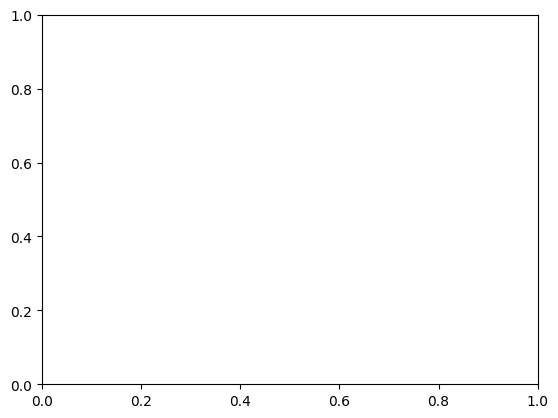

In [223]:
plt.figure(2)
plt.plot([10,100,1000], res[:,0], label="SWD")
plt.fill_between([10,100,1000], res[:,0] - 2 * res[:,1], res[:,0] + 2 * res[:,1], alpha=0.5)

plt.legend()
plt.xscale('log')

plt.xlabel("Number of projections")
plt.ylabel("Distance")
plt.title('Sliced Wasserstein Distance with 95% confidence inverval')

plt.show()

## Best models

In [141]:
df_bests_corr = list(df_best_corr["sliced_Wasserstein_mean"].values())

In [142]:
tmp=pd.concat(df_bests_corr)
tmp2=tmp[tmp["bijector"]=="MAFN"]
tmp2[tmp2["correlation"]=="corr"]

run_n  run_seed  ndims  nsamples correlation  nbijectors bijector  \
8      2         0      4    100000        corr           5     MAFN   
1      7         0      8    100000        corr          10     MAFN   
1     10         0     16    100000        corr           5     MAFN   
0     14         0     32    100000        corr           5     MAFN   
2     17         0     64    100000        corr           5     MAFN   
1     24         0    100    100000        corr          10     MAFN   
6     26         0    200    100000        corr           5     MAFN   
2     29         0    400    100000        corr           5     MAFN   
6     33         0   1000    100000        corr           5     MAFN   

  activation  spline_knots  range_min  eps_regulariser regulariser  \
8       relu             8         -5                0        None   
1       relu             8         -5                0        None   
1       relu             8         -5                0        None   
0       relu             8         -5                0        None   
2       relu             8         -5                0        None   
1       relu             8         -5                0        None   
6       relu             8         -5                0        None   
2       relu             8         -5                0        None   
6       relu             8         -5                0        None   

   kl_divergence  ks_test_mean  ks_test_median  ad_test_mean  ad_test_median  \
8             -1      0.504421        0.518005      0.223863        0.221983   
1             -1      0.471417        0.479054      0.218443        0.215214   
1             -1      0.488434        0.495043      0.215383        0.213272   
0             -1      0.489698        0.492980      0.217061        0.215439   
2             -1      0.476225        0.485904      0.213891        0.210892   
1             -1      0.342650        0.386332      0.181677        0.163237   
6             -1      0.434536        0.463177      0.207898        0.195557   
2             -1      0.476258        0.496130      0.214758        0.206075   
6             -1      0.009250        0.000030      0.001007        0.008588   

   sliced_Wasserstein_mean  sliced_Wasserstein_std  \
8                 0.021769                0.007086   
1                 0.025050                0.008638   
1                 0.025364                0.011847   
0                 0.021386                0.008449   
2                 0.034605                0.018001   
1                 0.051979                0.027734   
6                 0.072948                0.046231   
2                 0.051810                0.030934   
6                 0.414115                0.255882   

   sliced_Wasserstein_mean_mean  sliced_Wasserstein_mean_std  nruns  \
8                      0.028155                     0.007063     10   
1                      0.030646                     0.015187      9   
1                      0.029399                     0.004381      5   
0                      0.036246                     0.010819     10   
2                      0.056841                     0.027705     10   
1                      0.108544                     0.077898      4   
6                      0.134413                     0.053632     10   
2                      0.073034                     0.019117     10   
6                      0.289257                     0.215345     10   

   frob_norm hidden_layers  batch_size  epochs_input  epochs_output  \
8   0.023668   256-256-256         512          1000            361   
1   0.048585   128-128-128         512          1000            296   
1   0.548248   256-256-256         512          1000            326   
0   0.121839   256-256-256         512          1000            176   
2   0.276106   128-128-128         512          1000            317   
1   0.798253   256-256-256         512          1000            141   
6   2.869233   256-256-256     

## Plots

### Wasserstein distance

In [45]:
MsplineN_corr_WD = extract_lines(df_bests_corr,"MsplineN","corr","Wasserstein_median",True)
CsplineN_corr_WD = extract_lines(df_bests_corr,"CsplineN","corr","Wasserstein_median",True)
MAFN_corr_WD = extract_lines(df_bests_corr,"MAFN","corr","Wasserstein_median",True)
RealNVPN_corr_WD = extract_lines(df_bests_corr,"RealNVPN","corr","Wasserstein_median",True)

In [51]:
MsplineN_corr_WD

array([[4.00000000e+00, 2.72604752e-02, 1.23801975e-02, 4.00000000e+00],
       [8.00000000e+00, 2.96040318e-02, 8.79596674e-03, 7.00000000e+00],
       [1.60000000e+01, 1.67889368e-02, 4.81047550e-03, 9.00000000e+00],
       [3.20000000e+01, 2.72045912e-02, 6.88175638e-03, 1.30000000e+01],
       [6.40000000e+01, 2.21509036e-02, 4.17268194e-03, 1.70000000e+01],
       [1.00000000e+02, 5.75401668e-02, 1.84324141e-02, 2.40000000e+01],
       [2.00000000e+02, 5.06564691e-02, 5.78156045e-02, 2.70000000e+01],
       [4.00000000e+02, 3.02736547e-02, 1.28453565e-02, 2.90000000e+01],
       [1.00000000e+03, 2.40329724e-02, 0.00000000e+00, 3.30000000e+01]])

/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


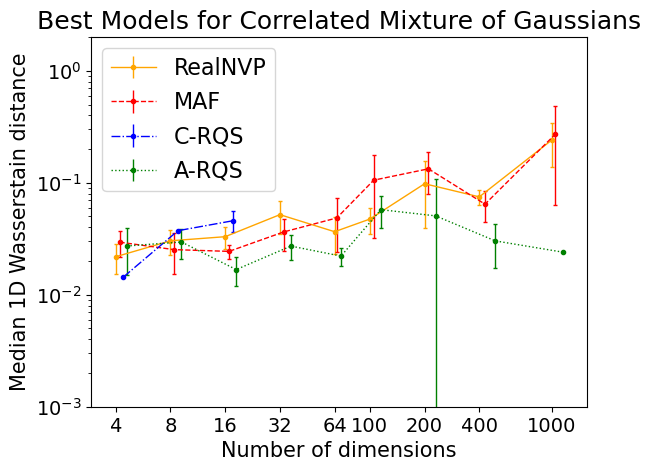

In [50]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = '.'#'go--'#'.'
fontsize_x=15
fontsize_y=15
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
spacing=20
[x,y,delta_y]=[RealNVPN_corr_WD[:,i] for i in [0,1,2]]
#plt.plot(x0,RealNVPN_corr_WD[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
plt.errorbar(x0,y,delta_y, fmt=point_marker, label='RealNVP', color='orange', linestyle="-", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
[x,y,delta_y]=[MAFN_corr_WD[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),1000)*1/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='MAF', color='red', linestyle="--", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
[x,y,delta_y]=[CsplineN_corr_WD[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),1000)*2/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='C-RQS', color='blue', linestyle="-.", linewidth=linewidth)
for i in range(len(x2)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
[x,y,delta_y]=[MsplineN_corr_WD[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),1000)*3/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='A-RQS', color='green', linestyle=":", linewidth=linewidth)
for i in range(len(x3)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
if labels:
    for i in MsplineN_corr_WD:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_WD:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_WD:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_WD:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('Median 1D Wasserstain distance', fontsize=fontsize_y)
plt.ylim(0.001,2)
plt.title("Best Models for Correlated Mixture of Gaussians", fontsize=fontsize_title)
plt.legend(fontsize=fontsize_legend)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_WD_median_corr.pdf')
plt.show()
plt.close()

In [53]:
#jtplot.reset()
#linewidth = 0.3
#point_label_size = 8
#point_marker = '.' #'go--'
#plt.plot(MsplineN_corr_WD[:,0],MsplineN_corr_WD[:,1],point_marker, color='green', label='Mspline (corr)', linestyle="-", linewidth=linewidth)
#for i in MsplineN_corr_WD:
#    plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
#plt.plot(MsplineN_uncorr_WD[:,0],MsplineN_uncorr_WD[:,1],point_marker, color='green', label='Mspline (uncorr)', linestyle=(0, (5, 8)), linewidth=linewidth)
#for i in MsplineN_uncorr_WD:
#    plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
#plt.plot(CsplineN_corr_WD[:,0],CsplineN_corr_WD[:,1],point_marker, color='blue', label='Cspline (corr)', linestyle="-", linewidth=linewidth)
#for i in CsplineN_corr_WD:
#    plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='blue')
#plt.plot(CsplineN_uncorr_WD[:,0],CsplineN_uncorr_WD[:,1],point_marker, color='blue', label='Cspline (uncorr)', linestyle=(0, (5, 8)), linewidth=linewidth)
#for i in CsplineN_uncorr_WD:
#    plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='blue')
#plt.plot(MAFN_corr_WD[:,0],MAFN_corr_WD[:,1],point_marker, color='red', label='MAF (corr)', linestyle="-", linewidth=linewidth)
#for i in MAFN_corr_WD:
#    plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
#plt.plot(MAFN_uncorr_WD[:,0],MAFN_uncorr_WD[:,1],point_marker, color='red', label='MAF (uncorr)', linestyle=(0, (5, 8)), linewidth=linewidth)
#for i in MAFN_uncorr_WD:
#    plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
#plt.plot(RealNVPN_corr_WD[:,0],RealNVPN_corr_WD[:,1],point_marker, color='orange', label='RealNVP (corr)', linestyle=(0, (5, 8)), linewidth=linewidth)
#for i in RealNVPN_corr_WD:
#    plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
#plt.plot(RealNVPN_uncorr_WD[:,0],RealNVPN_uncorr_WD[:,1],point_marker, color='orange', label='RealNVP (uncorr)', linestyle=(0, (5, 8)), linewidth=linewidth)
#for i in RealNVPN_uncorr_WD:
#    plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
#plt.xscale('log')
#plt.yscale('log')
#plt.xlabel('Number of dimensions')
#plt.ylabel('W-distance')
#plt.ylim(0,5)
#plt.title("Corr. MoG: median Wasserstein distance for best models")
##lt.ylim(max(MsplineN_corr_WD[:,1]), min(MsplineN_corr_WD[:,1]))
#plt.legend()
#plt.savefig(paper_fig_dir + 'Best_WD_median_corr.pdf')
#plt.show()
#plt.close()

### KS

In [58]:
MsplineN_corr_KS = extract_lines(df_bests_corr,"MsplineN","corr","ks_test_median")
MsplineN_uncorr_KS = extract_lines(df_bests_corr,"MsplineN","uncorr","ks_test_median")
CsplineN_corr_KS = extract_lines(df_bests_corr,"CsplineN","corr","ks_test_median")
CsplineN_uncorr_KS = extract_lines(df_bests_corr,"CsplineN","uncorr","ks_test_median")
MAFN_corr_KS = extract_lines(df_bests_corr,"MAFN","corr","ks_test_median")
MAFN_uncorr_KS = extract_lines(df_bests_corr,"MAFN","uncorr","ks_test_median")
RealNVPN_corr_KS = extract_lines(df_bests_corr,"RealNVPN","corr","ks_test_median")
RealNVPN_uncorr_KS = extract_lines(df_bests_corr,"RealNVPN","uncorr","ks_test_median")

/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric,"run_n"]].to_numpy().flatten().tolist()
/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric,"run_n"]].to_numpy().flatten().tolist()
/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric,"run_n"]].to_numpy().flatten().tolist()
/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric,"run_n"]].to_numpy().flatten().tolist()
/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame 

In [55]:
#KS_threshold=0.000000001
#MsplineN_corr_KS = np.array([x for x in MsplineN_corr_KS if x[1]>KS_threshold])
#MsplineN_uncorr_KS = np.array([x for x in MsplineN_uncorr_KS if x[1]>KS_threshold])
#CsplineN_corr_KS = np.array([x for x in CsplineN_corr_KS if x[1]>KS_threshold])
#CsplineN_uncorr_KS = np.array([x for x in CsplineN_uncorr_KS if x[1]>KS_threshold])
#MAFN_corr_KS = np.array([x for x in MAFN_corr_KS if x[1]>KS_threshold])
#MAFN_uncorr_KS = np.array([x for x in MAFN_uncorr_KS if x[1]>KS_threshold])
#RealNVPN_corr_KS = np.array([x for x in RealNVPN_corr_KS if x[1]>KS_threshold])
#RealNVPN_uncorr_KS = np.array([x for x in RealNVPN_uncorr_KS if x[1]>KS_threshold])

/tmp/ipykernel_89/2555757080.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "go--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(RealNVPN_corr_KS[:,0],RealNVPN_corr_KS[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
/tmp/ipykernel_89/2555757080.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(RealNVPN_corr_KS[:,0],RealNVPN_corr_KS[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
/tmp/ipykernel_89/2555757080.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "go--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(MAFN_corr_KS[:,0],MAFN_corr_KS[:,1],point_marker, color='red', label='MAF', linestyle="-", linewidth=l

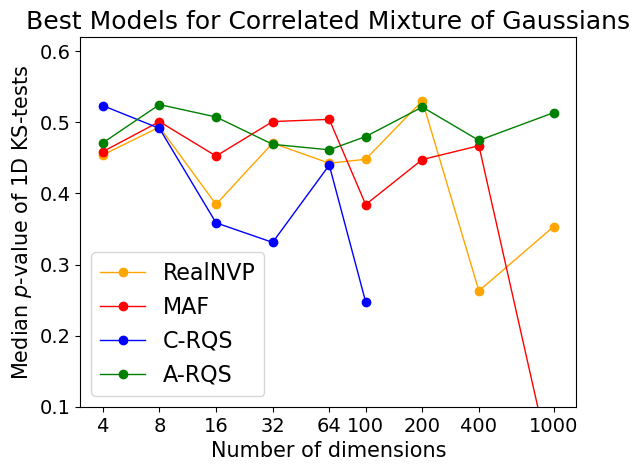

In [59]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = 'go--'#'.'
fontsize_x=15
fontsize_y=15
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
plt.plot(RealNVPN_corr_KS[:,0],RealNVPN_corr_KS[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
plt.plot(MAFN_corr_KS[:,0],MAFN_corr_KS[:,1],point_marker, color='red', label='MAF', linestyle="-", linewidth=linewidth)
plt.plot(CsplineN_corr_KS[:,0],CsplineN_corr_KS[:,1],point_marker, color='blue', label='C-RQS', linestyle="-", linewidth=linewidth)
plt.plot(MsplineN_corr_KS[:,0],MsplineN_corr_KS[:,1],point_marker, color='green', label='A-RQS', linestyle="-", linewidth=linewidth)
if labels:
    for i in MsplineN_corr_KS:
        plt.text(i[0]*0.85,i[1]*1, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_KS:
        plt.text(i[0]*1.05,i[1]*0.98, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_KS:
        plt.text(i[0]*1.05,i[1]*1.01, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_KS:
        plt.text(i[0]*0.85,i[1]*0.98, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('Median $p$-value of 1D KS-tests', fontsize=fontsize_y)
plt.ylim(0.1,0.62)
plt.title("Best Models for Correlated Mixture of Gaussians", fontsize=fontsize_title)
#lt.ylim(max(MsplineN_corr_WD[:,1]), min(MsplineN_corr_WD[:,1]))
plt.legend(fontsize=fontsize_legend)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_KS_median_corr.pdf')
plt.show()
plt.close()

In [57]:
#jtplot.reset()
#linewidth = 0.3
#point_label_size = 8
#point_marker = '.' #'go--'
#plt.plot(MsplineN_corr_KS[:,0],MsplineN_corr_KS[:,1],point_marker, color='green', label='Mspline (corr)', linestyle="solid", linewidth=linewidth)
#for i in MsplineN_corr_KS:
#    plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
#plt.plot(MsplineN_uncorr_KS[:,0],MsplineN_uncorr_KS[:,1],point_marker, color='green', label='Mspline (uncorr)', linestyle=(0, (5, 8)), linewidth=linewidth)
#for i in MsplineN_uncorr_KS:
#    plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
#plt.plot(CsplineN_corr_KS[:,0],CsplineN_corr_KS[:,1],point_marker, color='blue', label='Cspline (corr)', linestyle="solid", linewidth=linewidth)
#for i in CsplineN_corr_KS:
#    plt.text(i[0]*1.05,i[1]*1.03, str(int(i[2])), fontsize=point_label_size, color='blue')
#plt.plot(CsplineN_uncorr_KS[:,0],CsplineN_uncorr_KS[:,1],point_marker, color='blue', label='Cspline (uncorr)', linestyle=(0, (5, 8)), linewidth=linewidth)
#for i in CsplineN_uncorr_KS:
#    plt.text(i[0]*1.05,i[1]*0.95, str(int(i[2])), fontsize=point_label_size, color='blue')
#plt.plot(MAFN_corr_KS[:,0],MAFN_corr_KS[:,1],point_marker, color='red', label='MAF (corr)', linestyle="solid", linewidth=linewidth)
#for i in MAFN_corr_KS:
#    plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
#plt.plot(MAFN_uncorr_KS[:,0],MAFN_uncorr_KS[:,1],point_marker, color='red', label='MAF (uncorr)', linestyle=(0, (5, 8)), linewidth=linewidth)
#for i in MAFN_uncorr_KS:
#    plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
#plt.plot(RealNVPN_corr_KS[:,0],RealNVPN_corr_KS[:,1],point_marker, color='orange', label='RealNVP (corr)', linestyle="solid", linewidth=linewidth)
#for i in RealNVPN_corr_KS:
#    plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
#plt.plot(RealNVPN_uncorr_KS[:,0],RealNVPN_uncorr_KS[:,1],point_marker, color='orange', label='RealNVP (uncorr)', linestyle=(0, (5, 8)), linewidth=linewidth)
#for i in RealNVPN_uncorr_KS:
#    plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
#plt.xscale('log')
##plt.yscale('log')
#plt.ylim(0.2,0.55)
#plt.title("Corr. MoG: median p-value of KS-test for best models")
##lt.ylim(max(MsplineN_corr_WD[:,1]), min(MsplineN_corr_WD[:,1]))
#plt.legend()
#plt.savefig(paper_fig_dir + 'Best_KS_median_corr.pdf')
#plt.show()
#plt.close()

### Frobenius-norm

In [53]:
MsplineN_corr_FN = extract_lines(df_bests_corr,"MsplineN","corr","frob_norm")
MsplineN_uncorr_FN = extract_lines(df_bests_corr,"MsplineN","uncorr","frob_norm")
CsplineN_corr_FN = extract_lines(df_bests_corr,"CsplineN","corr","frob_norm")
CsplineN_uncorr_FN = extract_lines(df_bests_corr,"CsplineN","uncorr","frob_norm")
MAFN_corr_FN = extract_lines(df_bests_corr,"MAFN","corr","frob_norm")
MAFN_uncorr_FN = extract_lines(df_bests_corr,"MAFN","uncorr","frob_norm")
RealNVPN_corr_FN = extract_lines(df_bests_corr,"RealNVPN","corr","frob_norm")
RealNVPN_uncorr_FN = extract_lines(df_bests_corr,"RealNVPN","uncorr","frob_norm")

/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric,"run_n"]].to_numpy().flatten().tolist()
/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric,"run_n"]].to_numpy().flatten().tolist()
/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric,"run_n"]].to_numpy().flatten().tolist()
/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric,"run_n"]].to_numpy().flatten().tolist()
/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame 

/tmp/ipykernel_89/2671916003.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "go--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(RealNVPN_corr_FN[:,0],RealNVPN_corr_FN[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
/tmp/ipykernel_89/2671916003.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(RealNVPN_corr_FN[:,0],RealNVPN_corr_FN[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
/tmp/ipykernel_89/2671916003.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "go--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(MAFN_corr_FN[:,0],MAFN_corr_FN[:,1],point_marker, color='red', label='MAF', linestyle="-", linewidth=l

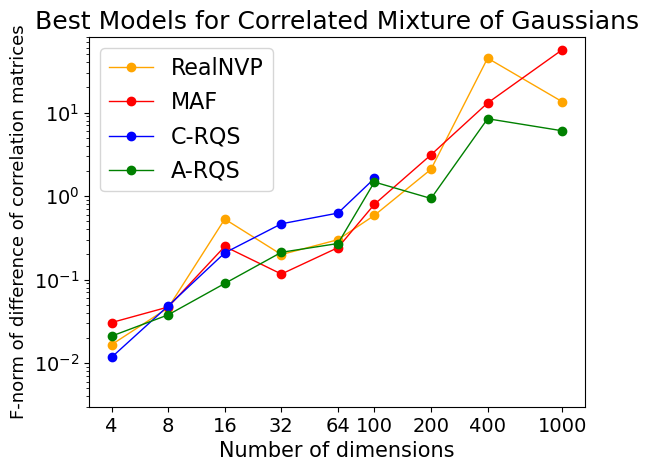

In [55]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = 'go--'#'.'
fontsize_x=15
fontsize_y=13
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
plt.plot(RealNVPN_corr_FN[:,0],RealNVPN_corr_FN[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
plt.plot(MAFN_corr_FN[:,0],MAFN_corr_FN[:,1],point_marker, color='red', label='MAF', linestyle="-", linewidth=linewidth)
plt.plot(CsplineN_corr_FN[:,0],CsplineN_corr_FN[:,1],point_marker, color='blue', label='C-RQS', linestyle="-", linewidth=linewidth)
plt.plot(MsplineN_corr_FN[:,0],MsplineN_corr_FN[:,1],point_marker, color='green', label='A-RQS', linestyle="-", linewidth=linewidth)
if labels:
    for i in MsplineN_corr_FN:
        plt.text(i[0]*0.85,i[1]*1, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_FN:
        plt.text(i[0]*1.05,i[1]*1.03, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_FN:
        plt.text(i[0]*1.05,i[1]*0.8, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_FN:
        plt.text(i[0]*0.85,i[1]*0.75, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('F-norm of difference of correlation matrices', fontsize=fontsize_y)
plt.ylim(0.003,80)
plt.title("Best Models for Correlated Mixture of Gaussians", fontsize=fontsize_title)
#lt.ylim(max(MsplineN_corr_WD[:,1]), min(MsplineN_corr_WD[:,1]))
plt.legend(fontsize=fontsize_legend)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_FN_corr.pdf')
plt.show()
plt.close()

### Training time

In [61]:
MsplineN_corr_time = extract_lines(df_bests_corr,"MsplineN","corr","time").astype(np.float)
MsplineN_uncorr_time = extract_lines(df_bests_corr,"MsplineN","uncorr","time").astype(np.float)
CsplineN_corr_time = extract_lines(df_bests_corr,"CsplineN","corr","time").astype(np.float)
CsplineN_uncorr_time = extract_lines(df_bests_corr,"CsplineN","uncorr","time").astype(np.float)
MAFN_corr_time = extract_lines(df_bests_corr,"MAFN","corr","time").astype(np.float)
MAFN_uncorr_time = extract_lines(df_bests_corr,"MAFN","uncorr","time").astype(np.float)
RealNVPN_corr_time = extract_lines(df_bests_corr,"RealNVPN","corr","time").astype(np.float)
RealNVPN_uncorr_time = extract_lines(df_bests_corr,"RealNVPN","uncorr","time").astype(np.float)

/tmp/ipykernel_89/1461121621.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  MsplineN_corr_time = extract_lines(df_bests_corr,"MsplineN","corr","time").astype(np.float)
/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric,"run_n"]].to_numpy().flatten().tolist()
/tmp/ipykernel_89/4218138265.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric,"run_n"]].to_numpy().flatten().tolist()
/tmp/ipykernel_89/4218138265.py:4: UserWarning: B

/tmp/ipykernel_89/1104397445.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "go--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(RealNVPN_corr_time[:,0],RealNVPN_corr_time[:,1],point_marker, color='orange', label='RealNVP', linestyle="solid", linewidth=linewidth)
/tmp/ipykernel_89/1104397445.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(RealNVPN_corr_time[:,0],RealNVPN_corr_time[:,1],point_marker, color='orange', label='RealNVP', linestyle="solid", linewidth=linewidth)
/tmp/ipykernel_89/1104397445.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "go--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(MAFN_corr_time[:,0],MAFN_corr_time[:,1],point_marker, color='red', label='MAF', linest

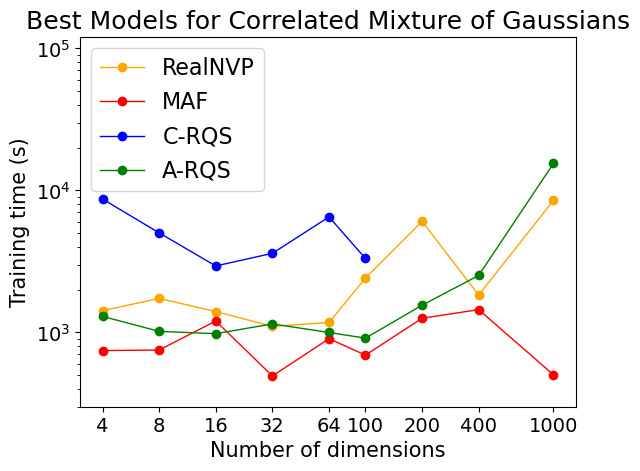

In [68]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = 'go--'#'.'
fontsize_x=15
fontsize_y=15
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
plt.plot(RealNVPN_corr_time[:,0],RealNVPN_corr_time[:,1],point_marker, color='orange', label='RealNVP', linestyle="solid", linewidth=linewidth)
plt.plot(MAFN_corr_time[:,0],MAFN_corr_time[:,1],point_marker, color='red', label='MAF', linestyle="solid", linewidth=linewidth)
plt.plot(CsplineN_corr_time[:,0],CsplineN_corr_time[:,1],point_marker, color='blue', label='C-RQS', linestyle="solid", linewidth=linewidth)
plt.plot(MsplineN_corr_time[:,0],MsplineN_corr_time[:,1],point_marker, color='green', label='A-RQS', linestyle="solid", linewidth=linewidth)
if labels:
    for i in MsplineN_corr_time:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_time:
        plt.text(i[0]*1.05,i[1]*1.03, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_time:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_time:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('Training time (s)', fontsize=fontsize_y)
plt.ylim(300,120000)
plt.title("Best Models for Correlated Mixture of Gaussians", fontsize=fontsize_title)
#lt.ylim(max(MsplineN_corr_WD[:,1]), min(MsplineN_corr_WD[:,1]))
plt.legend(fontsize=fontsize_legend)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_training_time_corr.pdf')
plt.show()
plt.close()

## Tables

In [143]:
df_bests_corr[0]

run_n  run_seed  ndims  nsamples correlation  nbijectors  bijector  \
0      4         0      4    100000        corr           2  MsplineN   
1      7         0      4    100000        corr          10  CsplineN   
5      4         0      4    100000        corr          10  RealNVPN   
8      2         0      4    100000        corr           5      MAFN   

  activation  spline_knots  range_min  eps_regulariser regulariser  \
0       relu            12        -16                0        None   
1       relu             8        -16                0        None   
5       relu             8         -5                0        None   
8       relu             8         -5                0        None   

   kl_divergence  ks_test_mean  ks_test_median  ad_test_mean  ad_test_median  \
0             -1      0.484862        0.483977      0.215978        0.214231   
1             -1      0.525661        0.523440      0.222253        0.222633   
5             -1      0.506393        0.509441      0.219049        0.220097   
8             -1      0.504421        0.518005      0.223863        0.221983   

   sliced_Wasserstein_mean  sliced_Wasserstein_std  \
0                 0.015517                0.005144   
1                 0.016277                0.005755   
5                 0.019917                0.007522   
8                 0.021769                0.007086   

   sliced_Wasserstein_mean_mean  sliced_Wasserstein_mean_std  nruns  \
0                      0.026894                     0.009631     10   
1                      0.023468                     0.007149      5   
5                      0.022365                     0.004709     10   
8                      0.028155                     0.007063     10   

   frob_norm hidden_layers  batch_size  epochs_input  epochs_output  \
0   0.020662   256-256-256         512          1000            237   
1   0.014546   128-128-128         512          1000            289   
5   0.007750   256-256-256         256          1000            337   
8   0.023668   256-256-256         512          1000            361   

           time  
0   1297.448962  
1  14023.302548  
5   3307.465860  
8    833.398603

In [150]:
for index, row in tmp.iterrows():
    if row["bijector"]=="RealNVPN":
        print(row["spline_knots"])
        row["spline_knots"]="--"
tmp

8
8
8
8
8
8
8
8
8


run_n  run_seed  ndims  nsamples correlation  nbijectors  bijector  \
0       4         0      4    100000        corr           2  MsplineN   
1       7         0      4    100000        corr          10  CsplineN   
5       4         0      4    100000        corr          10  RealNVPN   
8       2         0      4    100000        corr           5      MAFN   
0       5         0      8    100000        corr           5  RealNVPN   
1       7         0      8    100000        corr          10      MAFN   
3       7         0      8    100000        corr           2  MsplineN   
4      16         0      8    100000        corr           5  CsplineN   
0       9         0     16    100000        corr           2  MsplineN   
1      10         0     16    100000        corr           5      MAFN   
5      11         0     16    100000        corr          10  RealNVPN   
7      27         0     16    100000        corr           5  CsplineN   
0      14         0     32    100000        corr           5      MAFN   
1      13         0     32    100000        corr           2  MsplineN   
2      13         0     32    100000        corr           5  RealNVPN   
5      40         0     32    100000        corr           5  CsplineN   
0      17         0     64    100000        corr           5  RealNVPN   
1      17         0     64    100000        corr           2  MsplineN   
2      17         0     64    100000        corr           5      MAFN   
6      52         0     64    100000        corr           5  CsplineN   
0      23         0    100    100000        corr           2  MsplineN   
1      24         0    100    100000        corr          10      MAFN   
4      21         0    100    100000        corr           5  RealNVPN   
10     63         0    100    100000        corr           5  CsplineN   
0      27         0    200    100000        corr           2  MsplineN   
3      28         0    200    100000        corr          10  RealNVPN   
6      26         0    200    100000        corr           5      MAFN   
0      29         0    400    100000        corr           2  MsplineN   
2      29         0    400    100000        corr           5      MAFN   
5      32         0    400    100000        corr          10  RealNVPN   
0      33         0   1000    100000        corr           2  MsplineN   
3      35         0   1000    100000        corr          10  RealNVPN   
6      33         0   1000    100000        corr           5      MAFN   

   activation  spline_knots  range_min  eps_regulariser regulariser  \
0        relu            12        -16                0        None   
1        relu             8        -16                0        None   
5        relu             8         -5                0        None   
8        relu             8         -5                0        None   
0        relu             8         -5                0        None   
1        relu             8         -5                0        None   
3        relu            12        -16                0        None   
4        relu            12        -16                0        None   
0        relu             8        -16                0        None   
1        relu             8         -5                0        None   
5        relu             8         -5                0        None   
7        relu             8        -16                0        None   
0        relu             8         -5                0        None   
1        relu             8        -16                0        None   
2        relu             8         -5                0        None   
5        relu            12        -16                0        None   
0        relu             8         -5                0        None   
1        relu             8        -16                0        None   
2        relu             8         -5                0        None   
6        relu            12        -16                0        None

In [204]:
tmp=df_bests_corr[0]
tmp=tmp[tmp["correlation"]=="corr"]
tmp=tmp[["hidden_layers","nbijectors","bijector","spline_knots","sliced_Wasserstein_mean", "ks_test_median", "frob_norm","epochs_output","time"]]
tmp["sliced_Wasserstein_mean"]=tmp["sliced_Wasserstein_mean"].apply(lambda x: "{:.2e}".format(float(x)))
tmp["ks_test_median"]=tmp["ks_test_median"].apply(lambda x: "{:.2e}".format(float(x)))
tmp["frob_norm"]=tmp["frob_norm"].apply(lambda x: "{:.2e}".format(float(x)))
tmp["time"]=tmp["time"].apply(lambda x: int(float(x)))
tmp.loc[tmp["bijector"]=="RealNVPN","spline_knots"]="--"
tmp.loc[tmp["bijector"]=="MAFN","spline_knots"]="--"
tmp.replace("MsplineN","A-RQS")
tmp.replace("CsplineN","C-RQS")
tmp.replace("RealNVPN","RealNVP")
tmp.replace("MAFN","MAF")
tmp['hidden_layers'] = tmp['hidden_layers'].str.replace(r'(\d+)-(\d+)-(\d+)', r'$3\times \1$', regex=True)
string=tmp.to_latex(index=False)
print(string)

\begin{tabular}{lrlllllrr}
\toprule
hidden\_layers &  nbijectors & bijector & spline\_knots & sliced\_Wasserstein\_mean & ks\_test\_median & frob\_norm &  epochs\_output &  time \\
\midrule
\$3\textbackslash times 256\$ &           2 & MsplineN &           12 &                1.55e-02 &       4.84e-01 &  2.07e-02 &            237 &  1297 \\
\$3\textbackslash times 128\$ &          10 & CsplineN &            8 &                1.63e-02 &       5.23e-01 &  1.45e-02 &            289 & 14023 \\
\$3\textbackslash times 256\$ &          10 & RealNVPN &           -- &                1.99e-02 &       5.09e-01 &  7.75e-03 &            337 &  3307 \\
\$3\textbackslash times 256\$ &           5 &     MAFN &           -- &                2.18e-02 &       5.18e-01 &  2.37e-02 &            361 &   833 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_4688/211014991.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  string=tmp.to_latex(index=False)


In [168]:
tmp.loc[df["bijector"]=="RealNVPN","spline_knots"]

1    --
8    --
Name: spline_knots, dtype: object

# Re-evaluate models

In [47]:
def recompute_metrics(run):
    print("Recomputing metrics for run",run.replace("results.txt",""),".")
    start_all=timer()
    tmp = pd.read_csv(run)
    X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
    np.shape(X_data_nf)
    run_n=int(tmp["run_n"])
    run_seed=int(tmp["run_seed"])
    ndims=int(tmp["ndims"])
    nsamples=int(tmp["nsamples"])
    correlation=str(tmp["correlation"][0])
    nbijectors=int(tmp["nbijectors"])
    bijector=str(tmp["bijector"][0])
    activation=str(tmp["activation"][0])
    spline_knots=int(tmp["spline_knots"])
    range_min=int(tmp["range_min"])
    eps_regulariser=tmp["eps_regulariser"][0]
    regulariser=tmp["regulariser"][0]
    hidden_layers=str(tmp["hidden_layers"][0])
    batch_size=int(tmp["batch_size"])
    epochs_input=int(tmp["epochs_input"])
    epochs_output=int(tmp["epochs_output"])
    time=tmp["time"][0]
    reset_random_seeds(0)
    ncomp=3
    ntest_samples=100000
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy()
    start=timer()
    ks_mean,ks_std,ad_mean,ad_std,,wd_mean,wd_std,swd_mean,swd_std,fn_mean,fn_std=Metrics.ComputeMetrics(X_data_test,X_data_nf)
    results_dict = {'run_n': [run_n],
                    'run_seed': [run_seed],
                    'ndims':[ndims],
                    'nsamples':[nsamples],
                    'correlation':[correlation],
                    'nbijectors':[nbijectors],
                    'bijector':[bijector],
                    'activation':[activation],
                    'spline_knots':[spline_knots],
                    'range_min':[range_min],
                    'eps_regulariser':[eps_regulariser],
                    'regulariser':[regulariser],
                    'kl_divergence':[kl_divergence],
                    'ks_test_mean':[ks_mean],
                    'ks_test_median':[ks_median],
                    'ad_test_mean':[ad_mean],
                    'ad_test_median':[ad_median],
                    'Wasserstein_median':[w_distance_median],
                    'Wasserstein_mean':[w_distance_mean],
                    'sliced_Wasserstein_mean':[swd_mean],
                    'sliced_Wasserstein_std':[swd_std],
                    'frob_norm':[frob_norm],
                    'hidden_layers':[hidden_layers],
                    'batch_size':[batch_size],
                    'epochs_input':[epochs_input],
                    'epochs_output':[epochs_output],
                    'time':[time]}
    os.rename(run, run.replace(".txt","_old.txt"))
    Utils.results_current(run.replace("results.txt",""),results_dict)
    tmp_new = pd.read_csv(run)
    end=timer()
    print("Metrics for run",run.replace("results.txt",""),"computed and saved in",end-start,"s.")
    return tmp

In [48]:
run=list(correlated_unc_results_paths.values())[0]+"4D/run_5/results.txt"
pd.read_csv(run)
recompute_metrics(run)

Recomputing metrics for run ../CMoG/results/MAFN_best/4D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:187: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([x_estimated[:,dim], batch_test[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:187: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([x_estimated[:,dim], batch_test[:,dim]])[2]


Metrics for run ../CMoG/results/MAFN_best/4D/run_5/ computed and saved in 1.2691607510000722 s.


run_n  run_seed  ndims  nsamples correlation  nbijectors bijector  \
0      5       520      4    100000        corr           5     MAFN   

  activation  spline_knots  range_min  ...  Wasserstein_median  \
0       relu             8         -5  ...            0.025781   

  Wasserstein_mean  sliced_Wasserstein_mean  sliced_Wasserstein_std  \
0         0.025781                 0.017306                0.001822   

   frob_norm  hidden_layers  batch_size  epochs_input  epochs_output  \
0   0.010386    128-128-128         512          1000            652   

          time  
0  7184.605105  

[1 rows x 27 columns]

In [105]:
tmp=
X_data_nf = np.load(list(correlated_unc_results_paths.values())[0]+"4D/run_5/nf_sample.npy")
np.shape(X_data_nf)
#arg_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
#X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy()

(100000, 4)

In [106]:
ndims=4
reset_random_seeds(0)

### Initialize number of components ###
def MixtureGaussian(ncomp,ndims,seed=0):
    targ_dist = MixtureDistributions.MixMultiNormal1(ncomp,ndims,seed=seed)
    return targ_dist
ntest_samples=100000
seed_dist = 0
seed_test = 0
targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy()
np.shape(X_data_test)
X_data_test[0]

array([4.2423981 , 7.12590057, 6.06101175, 9.83516205])

In [107]:
ks_mean,ks_std,ad_mean,ad_std,,wd_mean,wd_std,swd_mean,swd_std,fn_mean,fn_std=Metrics.ComputeMetrics(X_data_test,X_data_nf)
{'kl_divergence': kl_divergence,'ks_test_mean': ks_mean,'ks_test_median':ks_median,'ad_test_mean':ad_mean,'ad_test_median':ad_median,'Wasserstein_median':w_distance_median,'Wasserstein_mean':w_distance_mean,'frob_norm':frob_norm}

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:187: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([x_estimated[:,dim], batch_test[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:187: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([x_estimated[:,dim], batch_test[:,dim]])[2]


{'kl_divergence': -1,
 'ks_test_mean': 0.5001360132927927,
 'ks_test_median': 0.5071681592536929,
 'ad_test_mean': 0.20878356996181632,
 'ad_test_median': 0.21184494329967268,
 'Wasserstein_median': 0.02578086762691431,
 'Wasserstein_mean': 0.02578086762691431,
 'frob_norm': 0.010386194116092153}

# Old

In [151]:
# Set random seed for reproducibility
np.random.seed(42)

# Define mean and covariance matrices
mean1 = np.random.randn(1000)
cov1 = np.random.randn(1000,1000)
mean2 = np.random.randn(1000)
cov2 = np.random.randn(1000,1000)

# Generate two MVN random samples with same mean and covariance
n_samples = 100000
sample1 = np.random.multivariate_normal(mean1, cov1, size=n_samples)
sample2 = np.random.multivariate_normal(mean2, cov2, size=n_samples)

/tmp/ipykernel_10662/2417459388.py:12: RuntimeWarning: covariance is not positive-semidefinite.
  sample1 = np.random.multivariate_normal(mean1, cov1, size=n_samples)
/tmp/ipykernel_10662/2417459388.py:13: RuntimeWarning: covariance is not positive-semidefinite.
  sample2 = np.random.multivariate_normal(mean2, cov2, size=n_samples)


In [152]:
from scipy.stats import wasserstein_distance
from timeit import default_timer as timer

In [155]:
start=timer()
res = np.mean([wasserstein_distance(sample1[:,0],sample2[:,0]),wasserstein_distance(sample1[:,1],sample2[:,1])])
end=timer()
print(res)
print("SWD computed in",end-start,"s.")

0.3611000457556382
SWD computed in 0.11974661500426009 s.


In [156]:
n_slices=[10,20,30,50,100]
means=[]
stds=[]
for i in n_slices:
    print("Computing SWD for",i,"slices")
    start=timer()
    swd=[sliced_Wasserstein_distance(sample1, sample2, norm=True, n_slices=i, p=1, seed=None) for k in range(10)]
    means.append(np.mean(swd))
    stds.append(np.std(swd))
    end=timer()
    print("SWD for",i,"slices computed in",end-start,"s.")

Computing SWD for 10 slices
SWD for 10 slices computed in 13.37087254099606 s.
Computing SWD for 20 slices
SWD for 20 slices computed in 28.011276363991783 s.
Computing SWD for 30 slices
SWD for 30 slices computed in 42.616360687999986 s.
Computing SWD for 50 slices
SWD for 50 slices computed in 69.60400968199247 s.
Computing SWD for 100 slices
SWD for 100 slices computed in 135.5928650309943 s.


In [157]:
means

[1.1240666444239884,
 1.178620028730426,
 1.0345398202687348,
 1.0856285500872462,
 1.1349826566549233]

In [158]:
stds

[0.2821306524675983,
 0.24819902027034105,
 0.13102079479750936,
 0.13262808573039866,
 0.10346581086159876]